In [1]:
# Traffic Data Preprocessing & Feature Selection Pipeline
# Cell-by-cell Jupyter notebook format for better understanding

# Cell 1: Import Required Libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Cell 2: Define the TrafficDataPreprocessor Class
class TrafficDataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.outlier_bounds = {}
        
    def load_and_explore_data(self, file_path):
        """Load data and perform initial exploration"""
        print("Loading and exploring the dataset...")
        
        # Load data
        df = pd.read_csv(file_path)
        
        # Clean column names (remove extra spaces)
        df.columns = df.columns.str.strip()
        
        # Basic info
        print(f"Dataset shape: {df.shape}")
        print(f"\nColumn names and types:")
        print(df.dtypes)
        
        # Check for missing values
        print(f"\nMissing values:")
        missing_values = df.isnull().sum()
        print(missing_values[missing_values > 0])
        
        # Convert data types properly
        df = self.convert_data_types(df)
        
        # Basic statistics
        print(f"\nBasic statistics for numerical columns:")
        print(df.describe())
        
        return df
    
    def convert_data_types(self, df):
        """Convert columns to appropriate data types"""
        print("Converting data types...")
        
        # Define columns that should be numeric
        numeric_columns = [
            'distance_km', 'distance_meters', 'duration_normal_mins', 
            'duration_in_traffic_mins', 'traffic_ratio', 'hour_of_day',
            'num_alternative_routes', 'steps_count', 'route_complexity',
            'temperature_c', 'feels_like_c', 'humidity_percent', 'pressure_hpa',
            'wind_speed_ms', 'wind_direction_degrees', 'cloud_coverage_percent',
            'visibility_meters', 'rain_1h_mm', 'rain_3h_mm'
        ]
        
        # Convert numeric columns
        for col in numeric_columns:
            if col in df.columns:
                # Handle distance_km column (remove ' km' suffix)
                if col == 'distance_km':
                    df[col] = df[col].astype(str).str.replace(' km', '').str.replace(',', '')
                
                # Convert to numeric, handling any errors
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
                # Fill any NaN values that resulted from conversion errors
                if df[col].isnull().sum() > 0:
                    df[col].fillna(df[col].median(), inplace=True)
        
        # Define boolean columns
        boolean_columns = ['is_weekend', 'peak_hour', 'has_tolls']
        for col in boolean_columns:
            if col in df.columns:
                # Convert string boolean to actual boolean
                df[col] = df[col].astype(str).str.upper().map({'TRUE': True, 'FALSE': False})
        
        # Ensure timestamp is datetime
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        print("Data type conversion completed")
        return df
    
    def handle_missing_values(self, df):
        """Handle missing values in the dataset"""
        print("\nHandling missing values...")
        
        # Check missing values before processing
        initial_missing = df.isnull().sum().sum()
        print(f"Total missing values before processing: {initial_missing}")
        
        # For numerical columns, fill with median
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        for col in numerical_cols:
            if df[col].isnull().sum() > 0:
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)
                print(f"Filled {col} missing values with median: {median_val}")
        
        # For categorical columns, fill with mode
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if df[col].isnull().sum() > 0:
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
                print(f"Filled {col} missing values with mode: {mode_val}")
        
        # Check missing values after processing
        final_missing = df.isnull().sum().sum()
        print(f"Total missing values after processing: {final_missing}")
        
        return df
    
    def detect_and_handle_outliers(self, df):
        """Detect and handle outliers using IQR method"""
        print("\nDetecting and handling outliers...")
        
        # Define columns to check for outliers
        outlier_cols = ['distance_km', 'duration_normal_mins', 'duration_in_traffic_mins', 
                       'traffic_ratio', 'temperature_c', 'humidity_percent', 'wind_speed_ms']
        
        outliers_removed = 0
        
        for col in outlier_cols:
            if col in df.columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                # Store bounds for future use
                self.outlier_bounds[col] = (lower_bound, upper_bound)
                
                # Count outliers
                outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
                
                if outlier_count > 0:
                    print(f"{col}: {outlier_count} outliers detected (bounds: {lower_bound:.2f}, {upper_bound:.2f})")
                    
                    # Cap outliers instead of removing them to preserve data
                    df[col] = np.clip(df[col], lower_bound, upper_bound)
                    outliers_removed += outlier_count
        
        print(f"Total outliers capped: {outliers_removed}")
        return df
    
    def preprocess_datetime(self, df):
        """Preprocess datetime column and extract additional features"""
        print("\nPreprocessing datetime features...")
        
        # Convert timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        # Extract additional time-based features
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_month'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['year'] = df['timestamp'].dt.year
        df['day_of_year'] = df['timestamp'].dt.dayofyear
        
        # Create cyclical features for time
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
        
        print("Datetime features extracted successfully")
        return df
    
    def encode_categorical_variables(self, df):
        """Encode categorical variables"""
        print("\nEncoding categorical variables...")
        
        # Boolean columns
        boolean_cols = ['is_weekend', 'peak_hour', 'has_tolls']
        for col in boolean_cols:
            if col in df.columns:
                df[col] = df[col].astype(bool).astype(int)
        
        # Categorical columns for label encoding
        categorical_cols = ['origin', 'destination', 'day_of_week', 'time_period', 
                           'weather_condition', 'weather_description']
        
        for col in categorical_cols:
            if col in df.columns:
                le = LabelEncoder()
                df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
                self.label_encoders[col] = le
                print(f"Encoded {col} with {len(le.classes_)} unique categories")
        
        return df
    
    def engineer_features(self, df):
        """Engineer new features based on existing data"""
        print("\nEngineering new features...")
        
        # Ensure all required columns are numeric
        required_cols = ['temperature_c', 'humidity_percent', 'wind_speed_ms', 'visibility_meters',
                        'route_complexity', 'steps_count', 'has_tolls', 'num_alternative_routes',
                        'distance_km', 'duration_normal_mins', 'traffic_ratio', 'is_weekend']
        
        for col in required_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Fill any NaN values that might have resulted from conversion
        df[required_cols] = df[required_cols].fillna(df[required_cols].median())
        
        # Feature 1: Weather Impact Score
        df['weather_impact_score'] = (
            np.abs(df['temperature_c'] - 24) / 10 +
            df['humidity_percent'] / 100 +
            df['wind_speed_ms'] / 10 +
            (10000 - df['visibility_meters']) / 10000
        )
        
        # Feature 2: Route Complexity Index
        max_steps = df['steps_count'].max() if df['steps_count'].max() > 0 else 1
        max_alternatives = df['num_alternative_routes'].max() if df['num_alternative_routes'].max() > 0 else 1
        
        df['route_complexity_index'] = (
            df['route_complexity'] * 0.4 +
            (df['steps_count'] / max_steps) * 0.3 +
            df['has_tolls'] * 0.2 +
            (1 - df['num_alternative_routes'] / max_alternatives) * 0.1
        )
        
        print("Feature engineering completed")
        return df
    
    def normalize_features(self, df):
        """Normalize numerical features"""
        print("\nNormalizing numerical features...")
        
        # Select numerical columns to normalize
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_normalize = [col for col in numerical_cols if not col.endswith('_encoded')]
        
        # Exclude certain columns from normalization
        exclude_cols = ['year', 'month', 'day_of_month', 'hour', 'day_of_year', 
                       'is_weekend', 'peak_hour', 'has_tolls']
        cols_to_normalize = [col for col in cols_to_normalize if col not in exclude_cols]
        
        # Apply normalization
        df[cols_to_normalize] = self.scaler.fit_transform(df[cols_to_normalize])
        
        print(f"Normalized {len(cols_to_normalize)} numerical features")
        return df



In [3]:
# Cell 3: Initialize Preprocessor and Load Data
preprocessor = TrafficDataPreprocessor()

# Replace 'Sample1.csv' with your actual file path
file_path = '/Users/user/Desktop/TrafficNG/traffic_weather_data_lagos.csv'
print("=== STEP 1: LOADING AND EXPLORING DATA ===")
df = preprocessor.load_and_explore_data(file_path)



=== STEP 1: LOADING AND EXPLORING DATA ===
Loading and exploring the dataset...
Dataset shape: (28361, 30)

Column names and types:
city                         object
origin                       object
destination                  object
distance_km                  object
distance_meters               int64
duration_normal_mins          int64
duration_in_traffic_mins      int64
traffic_ratio               float64
timestamp                    object
day_of_week                  object
is_weekend                     bool
hour_of_day                   int64
peak_hour                      bool
time_period                  object
num_alternative_routes        int64
steps_count                   int64
has_tolls                      bool
route_complexity            float64
temperature_c               float64
feels_like_c                float64
humidity_percent            float64
pressure_hpa                float64
weather_condition            object
weather_description          object
wind

In [4]:
# Cell 3: Initialize Preprocessor and Load Data WITH Original Data Backup
preprocessor = TrafficDataPreprocessor()
file_path = '/Users/user/Desktop/TrafficNG/traffic_weather_data_lagos.csv'

print("=== STEP 1: LOADING AND EXPLORING DATA ===")
df = preprocessor.load_and_explore_data(file_path)

# ===== SAVE ORIGINAL DATA BEFORE ANY PREPROCESSING =====
print("\n=== SAVING ORIGINAL DATA FOR LATER USE ===")

# Save the completely original data (before any modifications)
original_df = df.copy()
print(f"✅ Original dataframe saved with shape: {original_df.shape}")
print(f"✅ Original columns: {list(original_df.columns)}")

# Also save the original target column specifically (before normalization)
if 'traffic_ratio' in original_df.columns:
    original_traffic_ratio = original_df['traffic_ratio'].copy()
    print(f"✅ Original traffic_ratio saved - Range: {original_traffic_ratio.min():.6f} to {original_traffic_ratio.max():.6f}")
else:
    print("⚠️  Warning: 'traffic_ratio' column not found in original data")
    original_traffic_ratio = None

# Optional: Save to CSV for backup
#backup_file_path = '/Users/user/Desktop/TrafficNG/original_traffic_data_backup.csv'
#try:
#    original_df.to_csv(backup_file_path, index=False)
#    print(f"✅ Original data also saved to: {backup_file_path}")
#except Exception as e:
#    print(f"⚠️  Could not save backup CSV: {e}")

# Display some original data info for verification
print(f"\n=== ORIGINAL DATA VERIFICATION ===")
print(f"Original shape: {original_df.shape}")
print(f"Original data types:")
print(original_df.dtypes)

if 'traffic_ratio' in original_df.columns:
    print(f"\nOriginal traffic_ratio statistics:")
    print(f"  Mean: {original_df['traffic_ratio'].mean():.6f}")
    print(f"  Std:  {original_df['traffic_ratio'].std():.6f}")
    print(f"  Min:  {original_df['traffic_ratio'].min():.6f}")
    print(f"  Max:  {original_df['traffic_ratio'].max():.6f}")

print(f"\nSample of original data:")
print(original_df.head(3))

print(f"\n{'='*60}")
print("✅ ORIGINAL DATA SUCCESSFULLY SAVED!")
print("✅ You can now proceed with preprocessing...")
print("✅ Use 'original_df' variable for inverse transformations later")
print(f"{'='*60}")

# Continue with your preprocessing as normal...
# The 'df' variable will be modified by preprocessing
# The 'original_df' variable will remain untouched

=== STEP 1: LOADING AND EXPLORING DATA ===
Loading and exploring the dataset...
Dataset shape: (28361, 30)

Column names and types:
city                         object
origin                       object
destination                  object
distance_km                  object
distance_meters               int64
duration_normal_mins          int64
duration_in_traffic_mins      int64
traffic_ratio               float64
timestamp                    object
day_of_week                  object
is_weekend                     bool
hour_of_day                   int64
peak_hour                      bool
time_period                  object
num_alternative_routes        int64
steps_count                   int64
has_tolls                      bool
route_complexity            float64
temperature_c               float64
feels_like_c                float64
humidity_percent            float64
pressure_hpa                float64
weather_condition            object
weather_description          object
wind

In [5]:
# Cell 4: Handle Missing Values
print("\n=== STEP 2: HANDLING MISSING VALUES ===")
df = preprocessor.handle_missing_values(df)




=== STEP 2: HANDLING MISSING VALUES ===

Handling missing values...
Total missing values before processing: 248
Filled weather_condition missing values with mode: Clouds
Filled weather_description missing values with mode: overcast clouds
Total missing values after processing: 0


In [6]:
# Cell 5: Preprocess Datetime Features
print("\n=== STEP 3: PREPROCESSING DATETIME FEATURES ===")
df = preprocessor.preprocess_datetime(df)




=== STEP 3: PREPROCESSING DATETIME FEATURES ===

Preprocessing datetime features...
Datetime features extracted successfully


In [7]:
# Cell 6: Detect and Handle Outliers
print("\n=== STEP 4: DETECTING AND HANDLING OUTLIERS ===")
df = preprocessor.detect_and_handle_outliers(df)



=== STEP 4: DETECTING AND HANDLING OUTLIERS ===

Detecting and handling outliers...
duration_in_traffic_mins: 577 outliers detected (bounds: -1.00, 71.00)
traffic_ratio: 1041 outliers detected (bounds: 0.47, 1.44)
temperature_c: 7 outliers detected (bounds: 19.21, 39.93)
Total outliers capped: 1625


In [8]:
# Cell 7: Encode Categorical Variables
print("\n=== STEP 5: ENCODING CATEGORICAL VARIABLES ===")
df = preprocessor.encode_categorical_variables(df)




=== STEP 5: ENCODING CATEGORICAL VARIABLES ===

Encoding categorical variables...
Encoded origin with 7 unique categories
Encoded destination with 2 unique categories
Encoded day_of_week with 7 unique categories
Encoded time_period with 4 unique categories
Encoded weather_condition with 3 unique categories
Encoded weather_description with 8 unique categories


In [9]:
# Cell 8: Feature Engineering
print("\n=== STEP 6: FEATURE ENGINEERING ===")
df = preprocessor.engineer_features(df)



=== STEP 6: FEATURE ENGINEERING ===

Engineering new features...
Feature engineering completed


In [10]:
# Cell 9: Normalize Features
print("\n=== STEP 7: NORMALIZING FEATURES ===")
df = preprocessor.normalize_features(df)




=== STEP 7: NORMALIZING FEATURES ===

Normalizing numerical features...
Normalized 25 numerical features


In [11]:
# Cell 10: Display Preprocessing Results
print("\n=== PREPROCESSING COMPLETED ===")
print(f"Final dataset shape: {df.shape}")
print(f"Total features: {len(df.columns)}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Display sample of key features
key_features = ['distance_km', 'traffic_ratio', 'weather_impact_score', 
               'route_complexity_index']
print("\nSample of key features:")
print(df[key_features].head())



=== PREPROCESSING COMPLETED ===
Final dataset shape: (28361, 47)
Total features: 47
Missing values: 0

Sample of key features:
   distance_km  traffic_ratio  weather_impact_score  route_complexity_index
0     0.643645      -0.640848             -0.158273               -0.920319
1    -1.432295      -0.778668             -0.158273                1.296584
2    -0.925968      -0.572438             -0.158273                0.672894
3    -0.075339      -0.401035             -0.158273                0.256164
4     1.858829      -0.805520             -0.158273               -1.847328



=== VISUALIZING ENGINEERED FEATURES ===


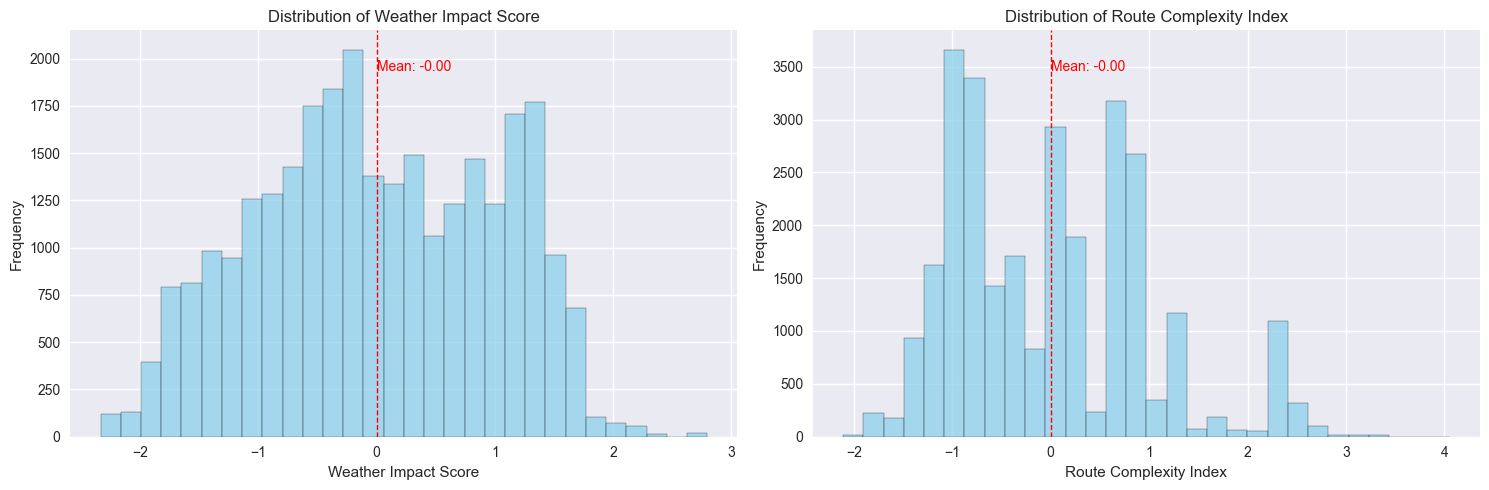

In [12]:
# Cell 11: Visualize Engineered Features
print("\n=== VISUALIZING ENGINEERED FEATURES ===")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # Single row with 2 columns

engineered_features = ['weather_impact_score', 'route_complexity_index']

for i, feature in enumerate(engineered_features):
    if feature in df.columns:
        axes[i].hist(df[feature], bins=30, alpha=0.7, edgecolor='black', color='skyblue')
        axes[i].set_title(f'Distribution of {feature.replace("_", " ").title()}')
        axes[i].set_xlabel(feature.replace("_", " ").title())
        axes[i].set_ylabel('Frequency')
        
        # Add vertical line at mean
        mean_val = df[feature].mean()
        axes[i].axvline(mean_val, color='red', linestyle='dashed', linewidth=1)
        axes[i].text(mean_val*1.05, axes[i].get_ylim()[1]*0.9, 
                    f'Mean: {mean_val:.2f}', color='red')

plt.tight_layout()
plt.show()

In [13]:
# Cell 12: Feature Selection Setup
print("\n=== FEATURE SELECTION METHODS ===")

# Prepare data for feature selection
# Assuming 'traffic_ratio' is our target variable
target_column = 'traffic_ratio'

# Get all numerical features for feature selection
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
if target_column in numerical_features:
    numerical_features.remove(target_column)

# Remove timestamp-related features that might not be useful
exclude_features = ['year', 'month', 'day_of_month', 'hour', 'day_of_year', 'timestamp']
numerical_features = [f for f in numerical_features if f not in exclude_features]

print(f"Total features available for selection: {len(numerical_features)}")
print(f"Target variable: {target_column}")





=== FEATURE SELECTION METHODS ===
Total features available for selection: 33
Target variable: traffic_ratio



=== METHOD 1: CORRELATION-BASED FEATURE SELECTION ===
Top 20 features by correlation with traffic_ratio:
 1. hour_cos: 0.5941
 2. duration_in_traffic_mins: 0.4444
 3. time_period_encoded: 0.4422
 4. humidity_percent: 0.3962
 5. temperature_c: 0.3846
 6. peak_hour: 0.3816
 7. feels_like_c: 0.3784
 8. is_weekend: 0.3516
 9. weather_impact_score: 0.3235
10. wind_speed_ms: 0.1760
11. weather_condition_encoded: 0.0927
12. cloud_coverage_percent: 0.0794
13. hour_of_day: 0.0757
14. has_tolls: 0.0701
15. steps_count: 0.0583
16. rain_1h_mm: 0.0507
17. day_sin: 0.0480
18. route_complexity: 0.0477
19. destination_encoded: 0.0425
20. day_cos: 0.0423


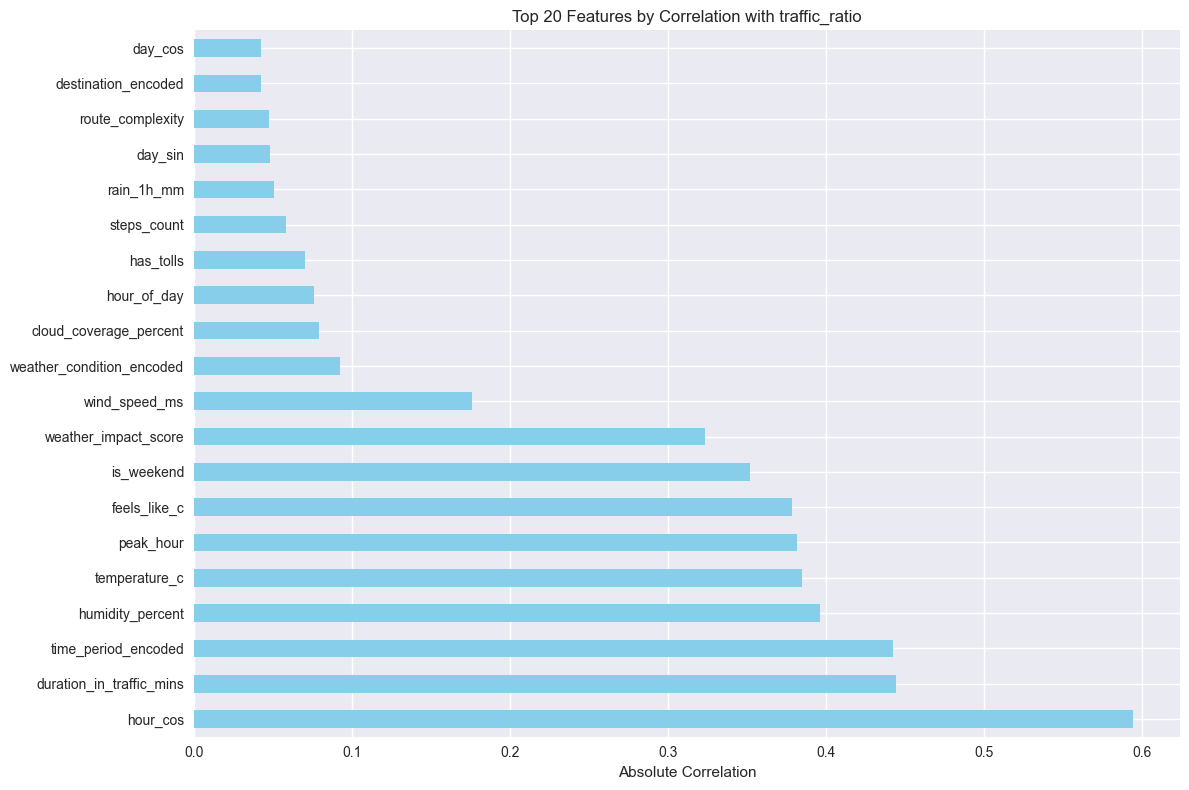

In [14]:
# Cell 13: Method 1 - Correlation-based Feature Selection
print("\n=== METHOD 1: CORRELATION-BASED FEATURE SELECTION ===")

def correlation_feature_selection(df, target_col, features, top_k=20):
    """Select top features based on correlation with target variable"""
    
    # Calculate correlation matrix
    corr_matrix = df[features + [target_col]].corr()
    
    # Get correlations with target variable
    target_corr = corr_matrix[target_col].abs().sort_values(ascending=False)
    
    # Remove target variable from results
    target_corr = target_corr.drop(target_col)
    
    # Get top k features
    top_features = target_corr.head(top_k)
    
    print(f"Top {top_k} features by correlation with {target_col}:")
    for i, (feature, corr) in enumerate(top_features.items(), 1):
        print(f"{i:2d}. {feature}: {corr:.4f}")
    
    # Visualize top correlations
    plt.figure(figsize=(12, 8))
    top_features.plot(kind='barh', color='skyblue')
    plt.title(f'Top {top_k} Features by Correlation with {target_col}')
    plt.xlabel('Absolute Correlation')
    plt.tight_layout()
    plt.show()
    
    return top_features.index.tolist()

# Apply correlation-based selection
correlation_features = correlation_feature_selection(df, target_column, numerical_features, top_k=20)



=== METHOD 2: PCA-BASED FEATURE SELECTION ===
Top 20 features by PCA importance:
 1. hour_of_day: 3.3258
 2. pressure_hpa: 3.1922
 3. cloud_coverage_percent: 2.8210
 4. time_period_encoded: 2.8141
 5. origin_encoded: 2.7813
 6. wind_direction_degrees: 2.6278
 7. num_alternative_routes: 2.4900
 8. wind_speed_ms: 2.4882
 9. route_complexity_index: 2.4790
10. hour_sin: 2.4499
11. rain_1h_mm: 2.4157
12. visibility_meters: 2.3298
13. peak_hour: 2.2965
14. hour_cos: 2.2288
15. steps_count: 2.2209
16. duration_in_traffic_mins: 2.0880
17. day_cos: 2.0360
18. day_sin: 1.9519
19. feels_like_c: 1.8189
20. is_weekend: 1.8007


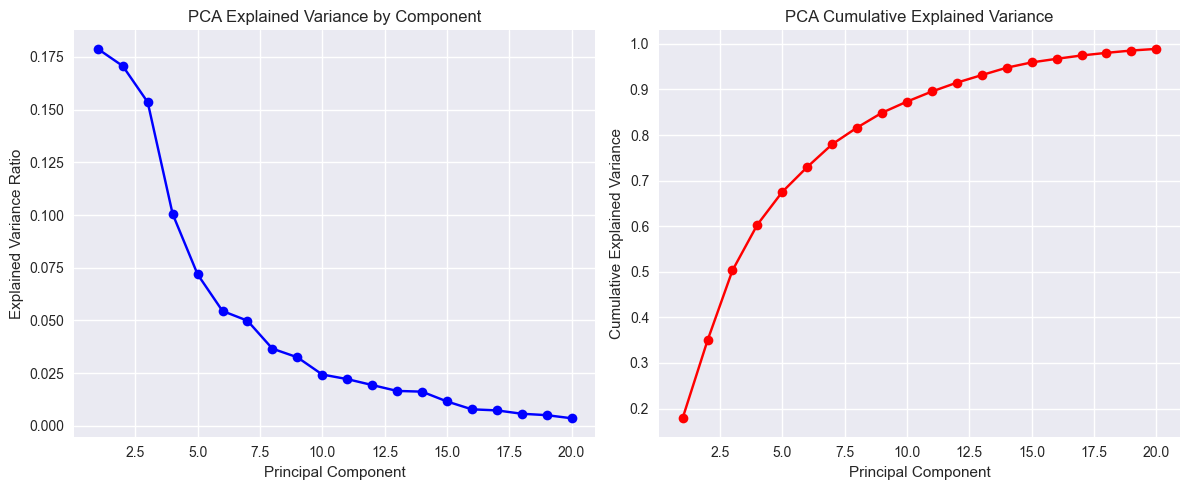

Total variance explained by 20 components: 0.9889


In [15]:
# Cell 14: Method 2 - PCA-based Feature Selection
print("\n=== METHOD 2: PCA-BASED FEATURE SELECTION ===")

def pca_feature_selection(df, features, n_components=20):
    """Select features using PCA dimensionality reduction"""
    
    # Prepare data
    X = df[features].fillna(df[features].median())
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Get feature loadings (importance)
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=features
    )
    
    # Calculate feature importance as sum of absolute loadings across all components
    feature_importance = loadings.abs().sum(axis=1).sort_values(ascending=False)
    
    print(f"Top {n_components} features by PCA importance:")
    for i, (feature, importance) in enumerate(feature_importance.head(20).items(), 1):
        print(f"{i:2d}. {feature}: {importance:.4f}")
    
    # Visualize explained variance
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_, 'bo-')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance by Component')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), 'ro-')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Cumulative Explained Variance')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Total variance explained by {n_components} components: {sum(pca.explained_variance_ratio_):.4f}")
    
    return feature_importance.head(20).index.tolist(), X_pca, pca

# Apply PCA-based selection
pca_features, X_pca, pca_model = pca_feature_selection(df, numerical_features, n_components=20)




Top 20 Features by PCA Importance:


,Feature,Importance
0,hour_of_day,3.3258
1,pressure_hpa,3.1922
2,cloud_coverage_percent,2.8210
3,time_period_encoded,2.8141
4,origin_encoded,2.7813
5,wind_direction_degrees,2.6278
6,num_alternative_routes,2.4900
7,wind_speed_ms,2.4882
8,route_complexity_index,2.4790
9,hour_sin,2.4499


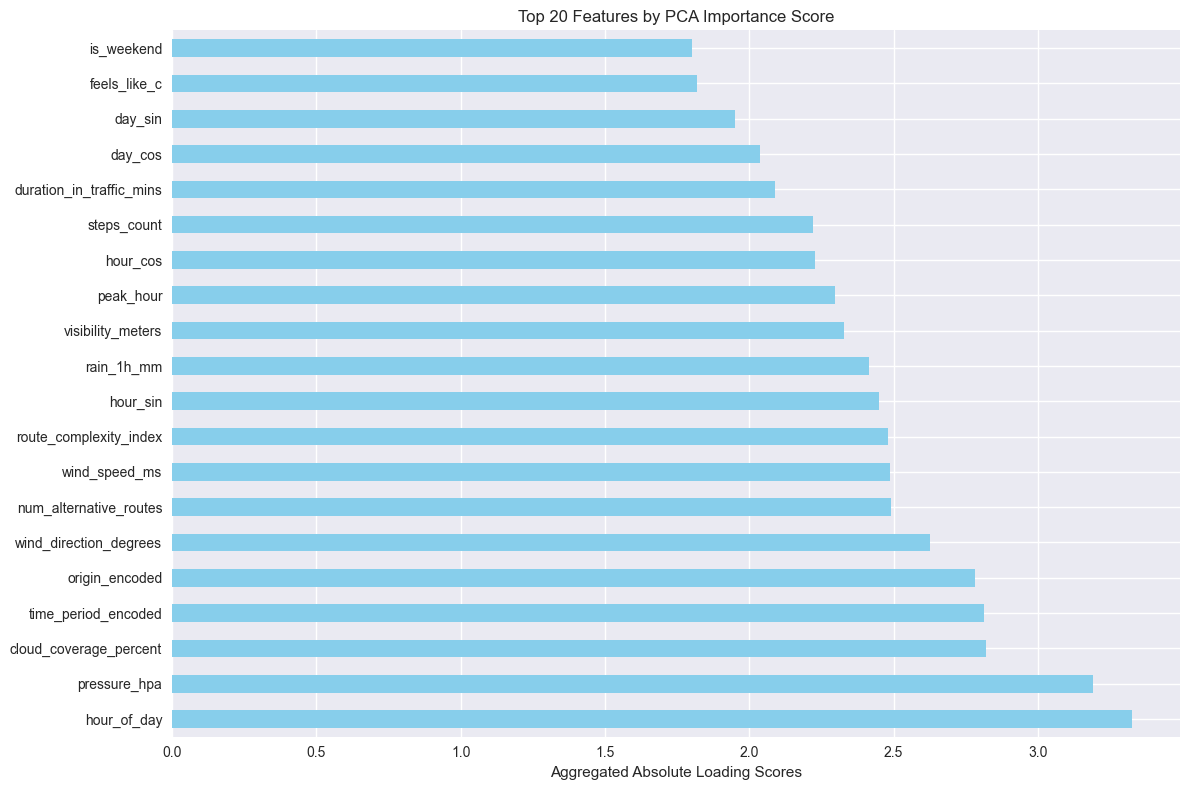

In [16]:
# Display top 20 PCA features
print("\nTop 20 Features by PCA Importance:")

# Get the feature importance from the PCA results
loadings = pd.DataFrame(
    pca_model.components_.T,
    columns=[f'PC{i+1}' for i in range(20)],
    index=numerical_features
)
feature_importance = loadings.abs().sum(axis=1).sort_values(ascending=False)

# Create and display the top features table
top_pca_features = pd.DataFrame({
    'Feature': feature_importance.index[:20],
    'Importance': feature_importance.values[:20]
})

# Display with styling
display(top_pca_features.style
       .background_gradient(cmap='Blues', subset=['Importance'])
       .format({'Importance': '{:.4f}'})
       .set_caption('Top 20 Features Selected by PCA'))

# Visualize PCA feature importance in the same style as MI plot
plt.figure(figsize=(12, 8))
feature_importance.head(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 Features by PCA Importance Score')
plt.xlabel('Aggregated Absolute Loading Scores')
plt.tight_layout()
plt.show()


=== METHOD 3: MUTUAL INFORMATION FEATURE SELECTION ===
Top 20 features by Mutual Information score:
 4. duration_in_traffic_mins: 1.6752
11. route_complexity: 0.5720
 2. distance_meters: 0.5546
 1. distance_km: 0.5499
 3. duration_normal_mins: 0.5463
 6. hour_of_day: 0.5142
33. route_complexity_index: 0.5090
 9. steps_count: 0.4795
26. origin_encoded: 0.4106
23. hour_cos: 0.3876
12. temperature_c: 0.3568
29. time_period_encoded: 0.3405
13. feels_like_c: 0.3279
32. weather_impact_score: 0.3186
14. humidity_percent: 0.2919
16. wind_speed_ms: 0.2389
25. day_cos: 0.2258
24. day_sin: 0.2233
22. hour_sin: 0.1682
10. has_tolls: 0.1632


<Figure size 1200x800 with 0 Axes>

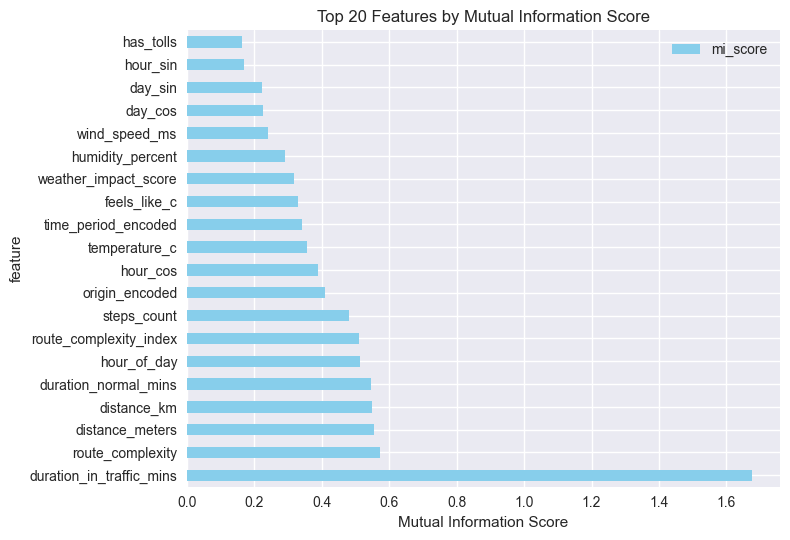

In [17]:
# Cell 15: Method 3 - Mutual Information Feature Selection
print("\n=== METHOD 3: MUTUAL INFORMATION FEATURE SELECTION ===")

def mutual_info_feature_selection(df, target_col, features, top_k=20):
    """Select features using mutual information to capture non-linear relationships"""
    
    # Prepare data
    X = df[features].fillna(df[features].median())
    y = df[target_col]
    
    # Calculate mutual information scores
    mi_scores = mutual_info_regression(X, y, random_state=42)
    
    # Create feature importance dataframe
    mi_df = pd.DataFrame({
        'feature': features,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    
    print(f"Top {top_k} features by Mutual Information score:")
    for i, row in mi_df.head(top_k).iterrows():
        print(f"{i+1:2d}. {row['feature']}: {row['mi_score']:.4f}")
    
    # Visualize mutual information scores
    plt.figure(figsize=(12, 8))
    mi_df.head(top_k).plot(x='feature', y='mi_score', kind='barh', color='skyblue')
    plt.title(f'Top {top_k} Features by Mutual Information Score')
    plt.xlabel('Mutual Information Score')
    plt.tight_layout()
    plt.show()
    
    return mi_df.head(top_k)['feature'].tolist()

# Apply mutual information selection
mi_features = mutual_info_feature_selection(df, target_column, numerical_features, top_k=20)



In [18]:
# Cell 16: Compare Feature Selection Methods
print("\n=== COMPARISON OF FEATURE SELECTION METHODS ===")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Correlation': correlation_features,
    'PCA': pca_features,
    'Mutual_Information': mi_features
})

print("Top 20 features from each method:")
print(comparison_df)

# Find common features across methods
common_features = set(correlation_features) & set(pca_features) & set(mi_features)
print(f"\nFeatures selected by all three methods ({len(common_features)}):")
for feature in common_features:
    print(f"- {feature}")

# Features selected by at least 2 methods
two_methods = set()
for i in range(len(correlation_features)):
    if correlation_features[i] in pca_features or correlation_features[i] in mi_features:
        two_methods.add(correlation_features[i])
for i in range(len(pca_features)):
    if pca_features[i] in mi_features:
        two_methods.add(pca_features[i])

print(f"\nFeatures selected by at least 2 methods ({len(two_methods)}):")
for feature in two_methods:
    print(f"- {feature}")




=== COMPARISON OF FEATURE SELECTION METHODS ===
Top 20 features from each method:
                  Correlation                       PCA  \
0                    hour_cos               hour_of_day   
1    duration_in_traffic_mins              pressure_hpa   
2         time_period_encoded    cloud_coverage_percent   
3            humidity_percent       time_period_encoded   
4               temperature_c            origin_encoded   
5                   peak_hour    wind_direction_degrees   
6                feels_like_c    num_alternative_routes   
7                  is_weekend             wind_speed_ms   
8        weather_impact_score    route_complexity_index   
9               wind_speed_ms                  hour_sin   
10  weather_condition_encoded                rain_1h_mm   
11     cloud_coverage_percent         visibility_meters   
12                hour_of_day                 peak_hour   
13                  has_tolls                  hour_cos   
14                steps_count   


=== FEATURE SELECTION SUMMARY AND RECOMMENDATIONS ===
RECOMMENDED FINAL FEATURE SET (25 features):
 1. origin_encoded
 2. hour_sin
 3. weather_impact_score
 4. cloud_coverage_percent
 5. wind_speed_ms
 6. humidity_percent
 7. duration_in_traffic_mins
 8. temperature_c
 9. day_sin
10. day_cos
11. is_weekend
12. steps_count
13. rain_1h_mm
14. hour_cos
15. has_tolls
16. hour_of_day
17. peak_hour
18. route_complexity_index
19. feels_like_c
20. route_complexity
21. time_period_encoded
22. pressure_hpa
23. distance_meters
24. distance_km
25. duration_normal_mins


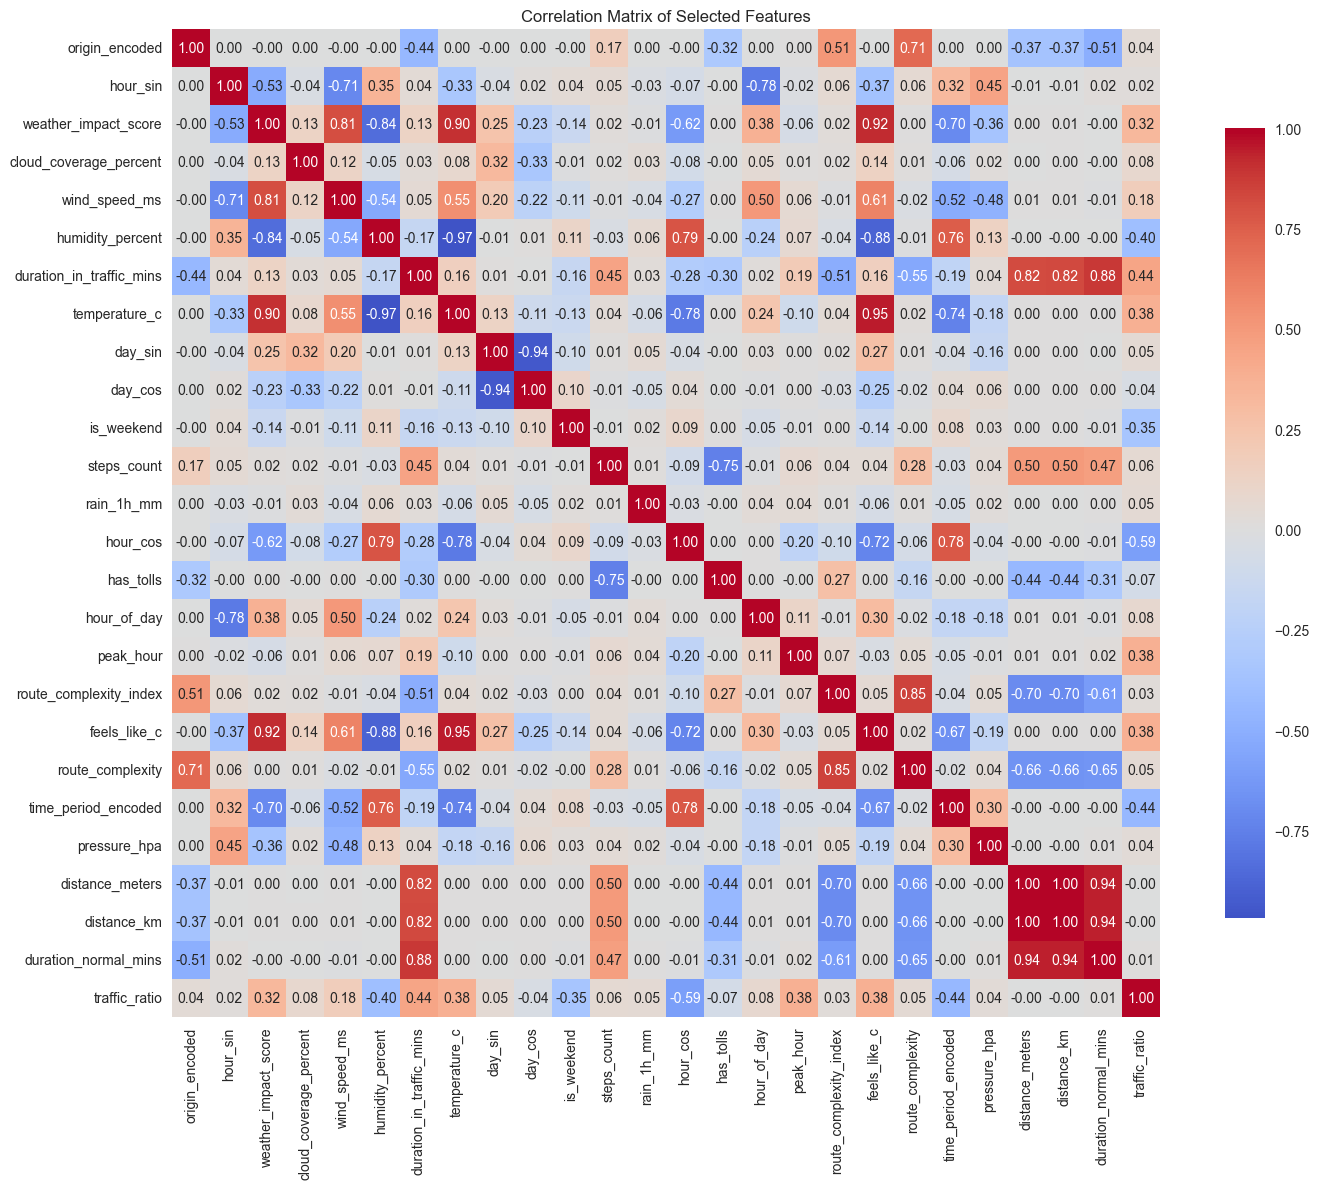

In [19]:
# Cell 17: Feature Selection Summary and Recommendations
print("\n=== FEATURE SELECTION SUMMARY AND RECOMMENDATIONS ===")

# Create final feature set combining insights from all methods
final_features = list(two_methods)  # Start with features selected by at least 2 methods

# Add top 5 from each method if not already included
for method_features in [correlation_features[:5], pca_features[:5], mi_features[:5]]:
    for feature in method_features:
        if feature not in final_features and len(final_features) < 25:
            final_features.append(feature)

print(f"RECOMMENDED FINAL FEATURE SET ({len(final_features)} features):")
for i, feature in enumerate(final_features, 1):
    print(f"{i:2d}. {feature}")

# Create correlation heatmap of final features
plt.figure(figsize=(15, 12))
corr_matrix = df[final_features + [target_column]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()



#MODELING

In [20]:
# Traffic Prediction Deep Learning Models Pipeline - Improved Version
# Cell-by-cell Jupyter notebook format with overfitting solutions

# Cell 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep Learning and Machine Learning
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import SpatialDropout1D
from keras.layers import Add, Activation
from keras.layers import GlobalAveragePooling1D
from keras.layers import Input, Reshape, Conv1D, BatchNormalization, Dropout, MaxPooling1D
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten, Input, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l1_l2
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import json
from datetime import datetime
from scipy import stats

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")



2025-09-08 16:54:27.384736: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


All libraries imported successfully!
TensorFlow version: 2.16.2
GPU Available: []


In [21]:
class TrafficModelPipeline:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.models = {}
        self.model_performances = {}
        self.feature_importance = {}
        self.predictions_dict = {}
        
    def prepare_features(self, df):
        """Prepare features based on your selection"""
        print("Preparing selected features...")
        
        # Your selected features
        numeric_features = [
            'duration_in_traffic_mins', 'wind_speed_ms', 
            'hour_of_day', 'weather_impact_score', 
            'route_complexity_index', 'rain_1h_mm', 'temperature_c', 
            'feels_like_c', 'humidity_percent', 'peak_hour', 
            'pressure_hpa', 'distance_meters'
        ]
        
        categorical_features = ['origin', 'destination', 'day_of_week']
        target_variable = 'traffic_ratio'
        
        # Check which features exist in the dataset
        available_numeric = [f for f in numeric_features if f in df.columns]
        available_categorical = [f for f in categorical_features if f in df.columns]
        
        print(f"Available numeric features: {len(available_numeric)}")
        print(f"Available categorical features: {len(available_categorical)}")
        
        # Handle missing target variable
        if target_variable not in df.columns:
            print(f"Target variable '{target_variable}' not found. Available columns:")
            print(df.columns.tolist())
            return None, None, None
        
        # Encode categorical variables
        for col in available_categorical:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            self.label_encoders[col] = le
            available_numeric.append(f'{col}_encoded')
        
        # Prepare final feature set
        X = df[available_numeric].fillna(df[available_numeric].median())
        y = df[target_variable]
        
        # Remove any remaining NaN values
        mask = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[mask]
        y = y[mask]
        
        print(f"Final feature matrix shape: {X.shape}")
        print(f"Target variable shape: {y.shape}")
        
        return X, y, available_numeric

# Initialize the pipeline
pipeline = TrafficModelPipeline()

# Prepare features directly from existing df
X, y, feature_names = pipeline.prepare_features(df)

if X is not None:
    print("Data preparation successful!")
    print(f"Features: {feature_names}")
    print(f"Target statistics:")
    print(f"  Mean: {y.mean():.4f}")
    print(f"  Std: {y.std():.4f}")
    print(f"  Min: {y.min():.4f}")
    print(f"  Max: {y.max():.4f}")
else:
    print("Data preparation failed!")

Preparing selected features...
Available numeric features: 12
Available categorical features: 3
Final feature matrix shape: (28361, 15)
Target variable shape: (28361,)
Data preparation successful!
Features: ['duration_in_traffic_mins', 'wind_speed_ms', 'hour_of_day', 'weather_impact_score', 'route_complexity_index', 'rain_1h_mm', 'temperature_c', 'feels_like_c', 'humidity_percent', 'peak_hour', 'pressure_hpa', 'distance_meters', 'origin_encoded', 'destination_encoded', 'day_of_week_encoded']
Target statistics:
  Mean: 0.0000
  Std: 1.0000
  Min: -1.9309
  Max: 2.5480


In [22]:
pipeline = TrafficModelPipeline()
X, y, feature_names = pipeline.prepare_features(df)

Preparing selected features...
Available numeric features: 12
Available categorical features: 3
Final feature matrix shape: (28361, 15)
Target variable shape: (28361,)


In [23]:
# Cell 4: Data Splitting and Scaling
print("Splitting data into train/validation/test sets...")

# Split the data: 60% train, 20% validation, 20% test (more balanced)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Scale the features
X_train_scaled = pipeline.scaler.fit_transform(X_train)
X_val_scaled = pipeline.scaler.transform(X_val)
X_test_scaled = pipeline.scaler.transform(X_test)

print("Data scaling completed!")



Splitting data into train/validation/test sets...
Training set shape: (17016, 15)
Validation set shape: (5672, 15)
Test set shape: (5673, 15)
Data scaling completed!


In [24]:
# Cell 5: Model Evaluation Functions
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance"""
    
    # Make predictions
    if hasattr(model, 'predict'):
        y_pred = model.predict(X_test)
        if len(y_pred.shape) > 1:
            y_pred = y_pred.flatten()
    else:
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    results = {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }
    
    # Store predictions for later comparison
    pipeline.predictions_dict[model_name] = y_pred
    
    print(f"\n{model_name} Performance:")
    print(f"  MSE: {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  R²: {r2:.6f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return results, y_pred

def plot_predictions(y_true, y_pred, model_name):
    """Plot prediction vs actual values"""
    plt.figure(figsize=(10, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Traffic Ratio')
    plt.ylabel('Predicted Traffic Ratio')
    plt.title(f'{model_name} - Prediction vs Actual')
    
    plt.subplot(1, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Traffic Ratio')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residual Plot')
    
    plt.tight_layout()
    plt.show()



=== MODEL 1: DENSE NEURAL NETWORK (IMPROVED) ===
Dense model created with input dimension: 15
Training Improved Dense Neural Network...
Epoch 1/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.3363 - mae: 1.0265 - val_loss: 6.5327 - val_mae: 0.7883 - learning_rate: 1.0000e-04
Epoch 2/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6492 - mae: 0.8641 - val_loss: 6.1896 - val_mae: 0.7543 - learning_rate: 1.0000e-04
Epoch 3/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1957 - mae: 0.7894 - val_loss: 5.8340 - val_mae: 0.7222 - learning_rate: 1.0000e-04
Epoch 4/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8146 - mae: 0.7491 - val_loss: 5.4710 - val_mae: 0.6949 - learning_rate: 1.0000e-04
Epoch 5/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4172 - mae: 0.7074 - val_loss: 5.0900 - val_mae: 0.6628 - learning_rate: 1.0000e-04
Epoch 6/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.0280 - mae: 0.6706 - val_loss: 4.7024 - val_mae: 0.6275 - learning_rate:

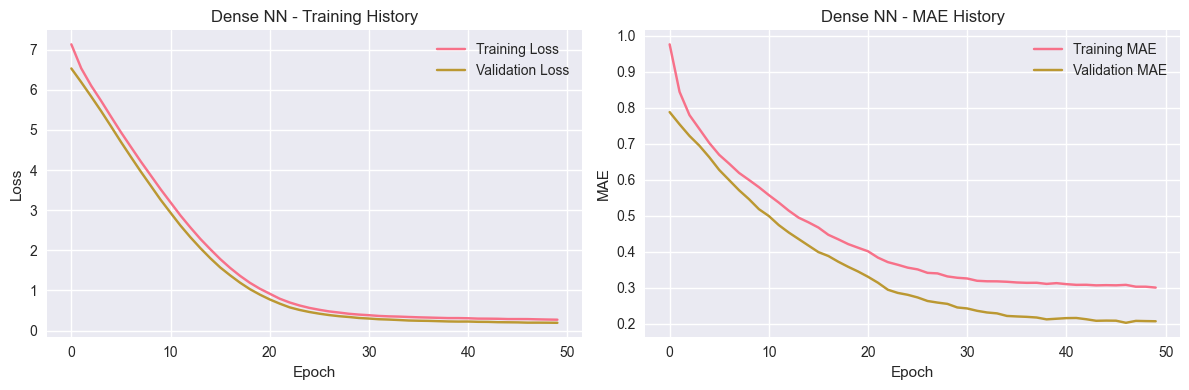

In [25]:
# Cell 6: Model 1 - Dense Neural Network (Improved with stronger regularization)
print("=== MODEL 1: DENSE NEURAL NETWORK (IMPROVED) ===")

def create_dense_model_improved(input_dim):
    """Create an improved dense neural network model with better regularization"""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.3),
        
        Dense(8, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Create and train improved dense model
dense_model = create_dense_model_improved(X_train_scaled.shape[1])
print(f"Dense model created with input dimension: {X_train_scaled.shape[1]}")

# More conservative callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
print("Training Improved Dense Neural Network...")
dense_history = dense_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,  # Reduced epochs
    batch_size=64,  # Larger batch size
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate dense model
dense_results, dense_pred = evaluate_model(dense_model, X_test_scaled, y_test, "Dense Neural Network")
pipeline.models['Dense_NN'] = dense_model
pipeline.model_performances['Dense_NN'] = dense_results

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dense_history.history['loss'], label='Training Loss')
plt.plot(dense_history.history['val_loss'], label='Validation Loss')
plt.title('Dense NN - Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dense_history.history['mae'], label='Training MAE')
plt.plot(dense_history.history['val_mae'], label='Validation MAE')
plt.title('Dense NN - MAE History')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()



In [26]:
# Cell 7: Model 2 - Simplified SVR
print("\n=== MODEL 2: SIMPLIFIED SUPPORT VECTOR MACHINE (SVR) ===")

def create_simple_svr_model():
    """Create a simplified SVR model with limited parameter search"""
    
    # Simplified parameter grid
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.1],
        'epsilon': [0.1, 0.2],
        'kernel': ['rbf', 'linear']
    }
    
    # Create SVR model
    svr = SVR()
    
    # Perform limited grid search
    print("Performing limited GridSearch for SVR...")
    grid_search = GridSearchCV(
        svr, param_grid, 
        cv=3,  # Reduced CV folds
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Use a sample of training data for faster training
    sample_size = min(1000, len(X_train_scaled))
    indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
    X_sample = X_train_scaled[indices]
    y_sample = y_train.iloc[indices]
    
    # Fit the model
    grid_search.fit(X_sample, y_sample)
    
    print(f"Best SVR parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {-grid_search.best_score_:.6f}")
    
    return grid_search.best_estimator_

# Create and train SVR model
svr_model = create_simple_svr_model()

# Evaluate SVR model
svr_results, svr_pred = evaluate_model(svr_model, X_test_scaled, y_test, "Support Vector Regression")
pipeline.models['SVR'] = svr_model
pipeline.model_performances['SVR'] = svr_results




=== MODEL 2: SIMPLIFIED SUPPORT VECTOR MACHINE (SVR) ===
Performing limited GridSearch for SVR...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best SVR parameters: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.103226

Support Vector Regression Performance:
  MSE: 0.091838
  RMSE: 0.303047
  MAE: 0.191717
  R²: 0.907809
  MAPE: 94.05%


In [27]:
# Cell 8: Model 3 - Enhanced TCNN (Improved Version)
print("\n=== MODEL 3: ENHANCED TEMPORAL CONVOLUTIONAL NEURAL NETWORK ===")

def create_tcnn_model_improved(input_shape):
    """Create an enhanced TCNN model with residual connections and deeper architecture"""
    inputs = Input(shape=(input_shape,))
    x = Reshape((input_shape, 1))(inputs)
    
    # First block with residual connection
    x1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(0.3)(x1)
    
    # Second block
    x2 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(0.3)(x2)
    
    # Residual connection
    res = Conv1D(64, kernel_size=1, padding='same')(x)
    x = Add()([x2, res])
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Third block
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    # Fourth block
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Global pooling
    x = GlobalAveragePooling1D()(x)
    
    # Dense layers with attention to important features
    x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    
    outputs = Dense(1, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )
    
    return model

# Enhanced callbacks for better training
#enhanced_callbacks = [
#    EarlyStopping(
 #       monitor='val_loss',
  #      patience=15,
   #     restore_best_weights=True,
    #    verbose=1
    #),
    #ReduceLROnPlateau(
     #   monitor='val_loss',
      #  factor=0.5,
       # patience=8,
        #min_lr=1e-7,
        #verbose=1
    #),
    #tf.keras.callbacks.LearningRateScheduler(
    #    lambda epoch: 0.001 * 0.95 ** epoch
    #)
#]

# Create and train improved TCNN model
tcnn_model = create_tcnn_model_improved(X_train_scaled.shape[1])
print(f"TCNN model created with input shape: {X_train_scaled.shape[1]}")

# Train the model
print("Training Improved Temporal Convolutional Neural Network...")
tcnn_history = tcnn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate TCNN model
tcnn_results, tcnn_pred = evaluate_model(tcnn_model, X_test_scaled, y_test, "Temporal CNN")
pipeline.models['TCNN'] = tcnn_model
pipeline.model_performances['TCNN'] = tcnn_results


=== MODEL 3: ENHANCED TEMPORAL CONVOLUTIONAL NEURAL NETWORK ===
TCNN model created with input shape: 15
Training Improved Temporal Convolutional Neural Network...
Epoch 1/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 5.3775 - mae: 1.5517 - root_mean_squared_error: 2.0004 - val_loss: 2.3986 - val_mae: 0.8330 - val_root_mean_squared_error: 1.0148 - learning_rate: 1.0000e-04
Epoch 2/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.2618 - mae: 1.3214 - root_mean_squared_error: 1.7007 - val_loss: 2.2845 - val_mae: 0.7224 - val_root_mean_squared_error: 0.9596 - learning_rate: 1.0000e-04
Epoch 3/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 3.7158 - mae: 1.1895 - root_mean_squared_error: 1.5339 - val_loss: 2.2731 - val_mae: 0.7224 - val_root_mean_squared_error: 0.9566 - learning_rate: 1.0000e-04
Epoch 4/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 3.3928 - mae: 1.1086 - root_mean_squared_error: 1.4268 - val_loss: 2.2502 - val_mae: 0.7187 - val_root_mean_squared_

In [28]:
# Cell 9: Model 4 - Improved LSTM Network
print("\n=== MODEL 4: IMPROVED LSTM NETWORK ===")

def prepare_lstm_data_improved(X_train, X_val, X_test, y_train, y_val, y_test, sequence_length=3):
    """Prepare data for LSTM with shorter sequences"""
    
    def create_sequences(data, target, seq_length):
        sequences = []
        targets = []
        for i in range(len(data) - seq_length + 1):
            sequences.append(data[i:i+seq_length])
            targets.append(target.iloc[i+seq_length-1])
        return np.array(sequences), np.array(targets)
    
    # Create sequences for LSTM
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)
    
    return X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq

def create_lstm_model_improved(input_shape):
    """Create improved LSTM model with better regularization"""
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=input_shape, 
             dropout=0.3, recurrent_dropout=0.3),
        BatchNormalization(),
        
        LSTM(16, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
        BatchNormalization(),
        
        Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.4),
        
        Dense(8, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Prepare LSTM data with shorter sequences
sequence_length = 3
X_train_lstm, X_val_lstm, X_test_lstm, y_train_lstm, y_val_lstm, y_test_lstm = prepare_lstm_data_improved(
    X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, sequence_length
)

print(f"LSTM input shape: {X_train_lstm.shape}")
print(f"LSTM target shape: {y_train_lstm.shape}")

# Create and train LSTM model
lstm_model = create_lstm_model_improved((sequence_length, X_train_scaled.shape[1]))

# Train the model
print("Training Improved LSTM Network...")
lstm_history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate LSTM model
lstm_results, lstm_pred = evaluate_model(lstm_model, X_test_lstm, y_test_lstm, "LSTM Network")
pipeline.models['LSTM'] = lstm_model
pipeline.model_performances['LSTM'] = lstm_results




=== MODEL 4: IMPROVED LSTM NETWORK ===
LSTM input shape: (17014, 3, 15)
LSTM target shape: (17014,)
Training Improved LSTM Network...
Epoch 1/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 2.5232 - mae: 1.0208 - val_loss: 1.6896 - val_mae: 0.8048 - learning_rate: 1.0000e-04
Epoch 2/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.9627 - mae: 0.8829 - val_loss: 1.6681 - val_mae: 0.8103 - learning_rate: 1.0000e-04
Epoch 3/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.7724 - mae: 0.8284 - val_loss: 1.6305 - val_mae: 0.8079 - learning_rate: 1.0000e-04
Epoch 4/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.7058 - mae: 0.8225 - val_loss: 1.5910 - val_mae: 0.8018 - learning_rate: 1.0000e-04
Epoch 5/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6226 - mae: 0.8031 - val_loss: 1.5531 - val_mae: 0.7958 - learning_rate: 1.0000e-04
Epoch 6/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.5852 - mae: 0.7995 - val_loss: 1.5160 - val_mae: 0.7895 - learning_rat

In [29]:
# Cell 10: Model 5 - Regularized Ensemble Model
print("\n=== MODEL 5: REGULARIZED ENSEMBLE MODEL ===")

def create_regularized_ensemble_model():
    """Create a regularized ensemble model"""
    
    # Base models for ensemble with regularization
    rf_model = RandomForestRegressor(
        n_estimators=50,  # Reduced
        max_depth=5,      # Reduced depth
        min_samples_split=10,  # Increased
        min_samples_leaf=5,    # Increased
        max_features='sqrt',   # Feature sampling
        random_state=42,
        n_jobs=-1
    )
    
    gb_model = GradientBoostingRegressor(
        n_estimators=50,   # Reduced
        learning_rate=0.05,  # Lower learning rate
        max_depth=3,       # Reduced depth
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,     # Stochastic gradient boosting
        random_state=42
    )
    
    # Use Ridge regression instead of Linear for meta-learner
    ridge_model = Ridge(alpha=1.0)
    
    # Train individual models
    print("Training Regularized Random Forest...")
    rf_model.fit(X_train_scaled, y_train)
    
    print("Training Regularized Gradient Boosting...")
    gb_model.fit(X_train_scaled, y_train)
    
    print("Training Ridge Regression...")
    ridge_model.fit(X_train_scaled, y_train)
    
    # Create voting ensemble
    voting_ensemble = VotingRegressor([
        ('rf', rf_model),
        ('gb', gb_model),
        ('ridge', ridge_model)
    ])
    
    print("Training Voting Ensemble...")
    voting_ensemble.fit(X_train_scaled, y_train)
    
    return voting_ensemble

# Create ensemble model
ensemble_model = create_regularized_ensemble_model()

# Evaluate ensemble model
ensemble_results, ensemble_pred = evaluate_model(
    ensemble_model, X_test_scaled, y_test, "Regularized Ensemble"
)

pipeline.models['Ensemble'] = ensemble_model
pipeline.model_performances['Ensemble'] = ensemble_results




=== MODEL 5: REGULARIZED ENSEMBLE MODEL ===
Training Regularized Random Forest...
Training Regularized Gradient Boosting...
Training Ridge Regression...
Training Voting Ensemble...

Regularized Ensemble Performance:
  MSE: 0.197470
  RMSE: 0.444376
  MAE: 0.327237
  R²: 0.801770
  MAPE: 124.91%



=== MODEL COMPARISON AND ANALYSIS ===
Model Performance Comparison:
                       Model       MSE      RMSE       MAE        R2  \
0       Dense Neural Network  0.081463  0.285418  0.200698  0.918223   
1  Support Vector Regression  0.091838  0.303047  0.191717  0.907809   
2               Temporal CNN  0.184381  0.429396  0.328141  0.814910   
4       Regularized Ensemble  0.197470  0.444376  0.327237  0.801770   
3               LSTM Network  0.290617  0.539089  0.407963  0.708246   

         MAPE  
0   83.014410  
1   94.045879  
2  163.655143  
4  124.914882  
3  163.145822  


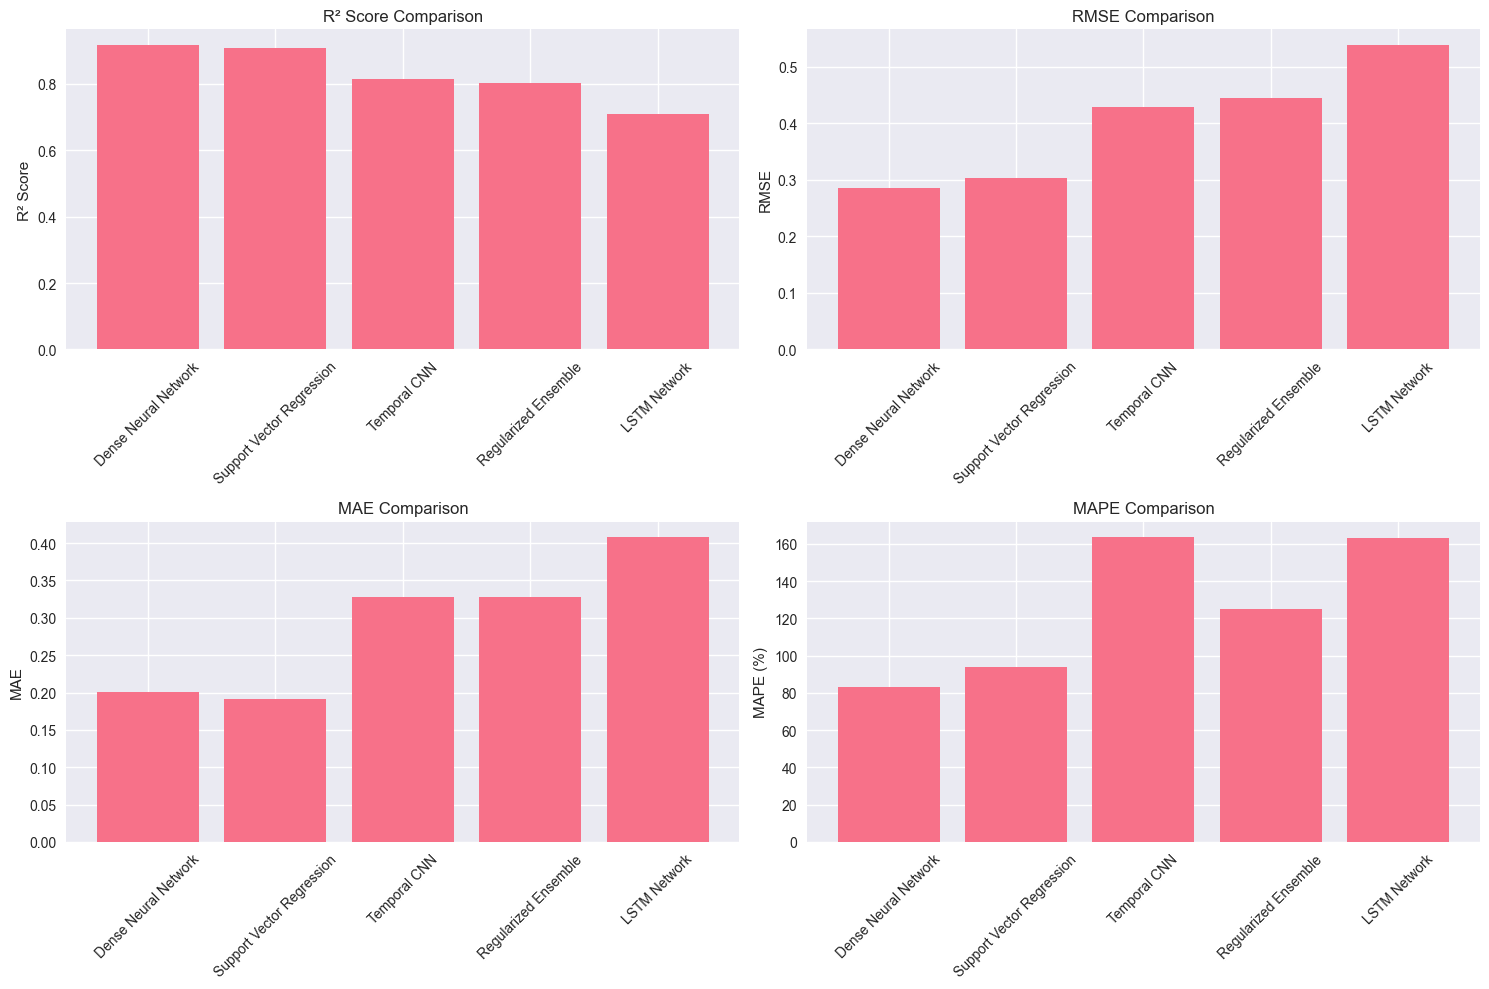


Best performing model: Dense Neural Network
Best R² Score: 0.918223


In [30]:
# Cell 11: Model Comparison and Analysis
print("\n=== MODEL COMPARISON AND ANALYSIS ===")

# Create comparison dataframe
comparison_data = []
for model_name, performance in pipeline.model_performances.items():
    comparison_data.append(performance)

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('R2', ascending=False)

print("Model Performance Comparison:")
print(comparison_df.round(6))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# R² Score comparison
axes[0,0].bar(comparison_df['Model'], comparison_df['R2'])
axes[0,0].set_title('R² Score Comparison')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[0,1].bar(comparison_df['Model'], comparison_df['RMSE'])
axes[0,1].set_title('RMSE Comparison')
axes[0,1].set_ylabel('RMSE')
axes[0,1].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1,0].bar(comparison_df['Model'], comparison_df['MAE'])
axes[1,0].set_title('MAE Comparison')
axes[1,0].set_ylabel('MAE')
axes[1,0].tick_params(axis='x', rotation=45)

# MAPE comparison
axes[1,1].bar(comparison_df['Model'], comparison_df['MAPE'])
axes[1,1].set_title('MAPE Comparison')
axes[1,1].set_ylabel('MAPE (%)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Best model identification
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")
print(f"Best R² Score: {comparison_df.iloc[0]['R2']:.6f}")



In [50]:
# Cell 12: Modified Observed vs Predicted Comparison with Original Values - SIMPLIFIED VISUALIZATIONS
print("\n=== OBSERVED VS PREDICTED COMPARISON (ORIGINAL VALUES) ===")

def calculate_prediction_intervals(model, X_test, y_test, confidence_level=0.95):
    """Calculate prediction intervals using bootstrap method"""
    n_bootstrap = 100
    predictions = []
    
    # Generate bootstrap samples
    for i in range(n_bootstrap):
        # Create bootstrap sample
        indices = np.random.choice(len(X_train_scaled), len(X_train_scaled), replace=True)
        X_boot = X_train_scaled[indices]
        y_boot = y_train.iloc[indices]
        
        # Train model on bootstrap sample
        if hasattr(model, 'fit'):
            if 'Neural Network' in str(model) or 'CNN' in str(model):
                # For neural networks, create a new model
                if 'Dense' in str(model):
                    boot_model = create_dense_model_improved(X_boot.shape[1])
                elif 'TCNN' in str(model):
                    boot_model = create_tcnn_model_improved(X_boot.shape[1])
                else:
                    boot_model = model
                
                boot_model.fit(X_boot, y_boot, epochs=20, batch_size=64, verbose=0)
                pred = boot_model.predict(X_test).flatten()
            else:
                # For sklearn models
                boot_model = type(model)(**model.get_params())
                boot_model.fit(X_boot, y_boot)
                pred = boot_model.predict(X_test)
            
            predictions.append(pred)
    
    # Calculate prediction intervals
    predictions = np.array(predictions)
    alpha = 1 - confidence_level
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100
    
    lower_bound = np.percentile(predictions, lower_percentile, axis=0)
    upper_bound = np.percentile(predictions, upper_percentile, axis=0)
    
    return lower_bound, upper_bound

def inverse_transform_target(y_normalized, target_scaler=None, target_column_name='traffic_ratio', 
                           original_data=None, preprocessor=None):
    """
    Inverse transform the normalized target values back to original scale
    
    Parameters:
    - y_normalized: normalized target values
    - target_scaler: if you have a separate scaler for target variable
    - target_column_name: name of the target column in original data
    - original_data: original dataframe before preprocessing
    - preprocessor: your TrafficDataPreprocessor instance
    """
    
    if target_scaler is not None:
        # If you have a dedicated target scaler
        return target_scaler.inverse_transform(y_normalized.reshape(-1, 1)).flatten()
    
    elif preprocessor is not None and hasattr(preprocessor, 'scaler'):
        # If the target was normalized with the main scaler
        try:
            # Get the feature names that were normalized
            feature_names = preprocessor.scaler.feature_names_in_
            if target_column_name in feature_names:
                # Find the index of the target column
                target_idx = list(feature_names).index(target_column_name)
                
                # Get the scale and mean for the target column
                scale = preprocessor.scaler.scale_[target_idx]
                mean = preprocessor.scaler.mean_[target_idx]
                
                # Inverse transform: original = (normalized * scale) + mean
                return (y_normalized * scale) + mean
            else:
                print(f"Warning: {target_column_name} not found in scaler features")
                return y_normalized
        except Exception as e:
            print(f"Error in inverse transform: {e}")
            return y_normalized
    
    elif original_data is not None and target_column_name in original_data.columns:
        # Calculate statistics from original data and manually inverse transform
        original_target = original_data[target_column_name]
        original_mean = original_target.mean()
        original_std = original_target.std()
        
        # Inverse standardization: original = (normalized * std) + mean
        return (y_normalized * original_std) + original_mean
    
    else:
        print("Warning: No inverse transformation method available. Returning normalized values.")
        return y_normalized

def display_observed_vs_predicted_original(model_name, y_true, y_pred, n_samples=10, 
                                         target_scaler=None, target_column_name='traffic_ratio',
                                         original_data=None, preprocessor=None, timestamps=None):
    """Display observed vs predicted values in ORIGINAL scale"""
    
    # Convert back to original scale
    y_true_original = inverse_transform_target(y_true, target_scaler, target_column_name, 
                                             original_data, preprocessor)
    y_pred_original = inverse_transform_target(y_pred, target_scaler, target_column_name, 
                                             original_data, preprocessor)
    
    # Convert to arrays for consistent indexing
    if hasattr(y_true_original, 'values'):
        y_true_original = y_true_original.values
    if hasattr(y_pred_original, 'values'):
        y_pred_original = y_pred_original.values
        
    # Select random samples - ensure we use valid indices
    max_idx = min(len(y_true_original), len(y_pred_original)) - 1
    n_samples = min(n_samples, max_idx + 1)
    indices = np.random.choice(max_idx + 1, n_samples, replace=False)
    
    print(f"\n{model_name} - Observed vs Predicted ORIGINAL VALUES (Sample of {n_samples} predictions):")
    print("-" * 95)
    print(f"{'Index':<6} {'Observed (Orig)':<15} {'Predicted (Orig)':<16} {'Difference':<12} {'Abs Error':<12} {'% Error':<10}")
    print("-" * 95)
    
    total_error = 0
    total_percent_error = 0
    
    for i, idx in enumerate(indices):
        observed_orig = y_true_original[idx]
        predicted_orig = y_pred_original[idx]
        difference = observed_orig - predicted_orig
        abs_error = abs(difference)
        percent_error = (abs_error / abs(observed_orig)) * 100 if abs(observed_orig) > 0 else 0
        
        total_error += abs_error
        total_percent_error += percent_error
        
        print(f"{idx:<6} {observed_orig:<15.6f} {predicted_orig:<16.6f} {difference:<12.6f} {abs_error:<12.6f} {percent_error:<10.2f}%")
    
    avg_error = total_error / n_samples
    avg_percent_error = total_percent_error / n_samples
    
    print("-" * 95)
    print(f"Average Absolute Error for these {n_samples} samples: {avg_error:.6f}")
    print(f"Average Percentage Error: {avg_percent_error:.2f}%")
    
    return indices, y_true_original, y_pred_original

def plot_scatter_observed_vs_predicted(model_name, y_true_orig, y_pred_orig):
    """Scatter plot for expected vs observed (all data)"""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true_orig, y_pred_orig, alpha=0.6, color='blue', s=50)
    plt.plot([y_true_orig.min(), y_true_orig.max()], [y_true_orig.min(), y_true_orig.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Observed Traffic Ratio')
    plt.ylabel('Predicted Traffic Ratio')
    plt.title(f'{model_name} - Expected vs Observed (Scatter Plot)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_timestamp_observed_vs_predicted(model_name, y_true_orig, y_pred_orig, timestamps):
    """Line chart for traffic ratio by timestamp"""
    plt.figure(figsize=(12, 6))
    
    # Ensure timestamps are in the right format and sorted
    if hasattr(timestamps, 'values'):
        timestamps = timestamps.values
        
    # If timestamps are not datetime objects, try to convert
    if not np.issubdtype(timestamps.dtype, np.datetime64):
        try:
            timestamps = pd.to_datetime(timestamps)
        except:
            print("Warning: Could not convert timestamps to datetime format. Using index instead.")
            timestamps = range(len(y_true_orig))
    
    # Sort by timestamp if possible
    if hasattr(timestamps, 'argsort'):
        sorted_indices = timestamps.argsort()
        sorted_timestamps = timestamps[sorted_indices]
        sorted_observed = y_true_orig[sorted_indices]
        sorted_predicted = y_pred_orig[sorted_indices]
    else:
        sorted_timestamps = timestamps
        sorted_observed = y_true_orig
        sorted_predicted = y_pred_orig
    
    plt.plot(sorted_timestamps, sorted_observed, 'b-', label='Observed', linewidth=2, alpha=0.8)
    plt.plot(sorted_timestamps, sorted_predicted, 'r-', label='Predicted', linewidth=2, alpha=0.8)
    
    # Format x-axis for timestamps if they are datetime objects
    if hasattr(sorted_timestamps, 'dtype') and np.issubdtype(sorted_timestamps.dtype, np.datetime64):
        plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
        plt.xlabel('Timestamp')
    else:
        plt.xlabel('Time Index')
        
    plt.ylabel('Traffic Ratio')
    plt.title(f'{model_name} - Traffic Ratio by Timestamp')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_bar_sample_predictions(model_name, y_true_orig, y_pred_orig, indices):
    """Bar chart for sample predictions vs actual"""
    plt.figure(figsize=(12, 6))
    sample_observed = y_true_orig[indices]
    sample_predicted = y_pred_orig[indices]
    
    x_pos = np.arange(len(indices))
    width = 0.35
    
    plt.bar(x_pos - width/2, sample_observed, width, label='Actual', color='blue', alpha=0.7)
    plt.bar(x_pos + width/2, sample_predicted, width, label='Predicted', color='red', alpha=0.7)
    
    plt.xlabel('Sample Index')
    plt.ylabel('Traffic Ratio')
    plt.title(f'{model_name} - Sample Predictions vs Actual (Bar Chart)')
    plt.legend()
    plt.xticks(x_pos, [f'S{i+1}' for i in range(len(indices))])
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

def analyze_model_performance_original(model_name, model, X_test, y_test, n_samples=10,
                                     target_scaler=None, target_column_name='traffic_ratio',
                                     original_data=None, preprocessor=None, timestamps=None):
    """Complete analysis of model performance with ORIGINAL VALUES - SIMPLIFIED"""
    
    print(f"\n{'='*70}")
    print(f"ANALYZING MODEL: {model_name} (ORIGINAL SCALE)")
    print(f"{'='*70}")
    
    # Debug information
    print(f"DEBUG INFO:")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"y_test type: {type(y_test)}")
    if hasattr(y_test, 'index'):
        print(f"y_test index range: {y_test.index.min()} to {y_test.index.max()}")
    if original_data is not None:
        print(f"original_data shape: {original_data.shape}")
        print(f"target column '{target_column_name}' in original_data: {target_column_name in original_data.columns}")
    if timestamps is not None:
        print(f"timestamps shape: {timestamps.shape if hasattr(timestamps, 'shape') else len(timestamps)}")
    
    # Make predictions
    if hasattr(model, 'predict'):
        if 'Neural Network' in model_name or 'CNN' in model_name:
            y_pred = model.predict(X_test).flatten()
        else:
            y_pred = model.predict(X_test)
    else:
        print(f"Error: Model {model_name} does not have predict method")
        return
    
    print(f"y_pred shape: {y_pred.shape}")
    
    # Display numerical comparison in original scale
    try:
        indices, y_true_orig, y_pred_orig = display_observed_vs_predicted_original(
            model_name, y_test, y_pred, n_samples, target_scaler, 
            target_column_name, original_data, preprocessor, timestamps
        )
    except Exception as e:
        print(f"Error in display function: {e}")
        print("Attempting with smaller sample size...")
        try:
            indices, y_true_orig, y_pred_orig = display_observed_vs_predicted_original(
                model_name, y_test, y_pred, min(5, len(y_test)), target_scaler, 
                target_column_name, original_data, preprocessor, timestamps
            )
        except Exception as e2:
            print(f"Error even with smaller sample: {e2}")
            return
    
    # Create SIMPLIFIED visualizations with original values
    plot_scatter_observed_vs_predicted(model_name, y_true_orig, y_pred_orig)
    
    # Use timestamp-based line chart if timestamps are provided
    if timestamps is not None:
        plot_timestamp_observed_vs_predicted(model_name, y_true_orig, y_pred_orig, timestamps)
    else:
        print("Warning: No timestamps provided. Using default line chart.")
        # Create a simple line chart without timestamps
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(y_true_orig)), y_true_orig, 'b-', label='Observed', linewidth=2, alpha=0.8)
        plt.plot(range(len(y_pred_orig)), y_pred_orig, 'r-', label='Predicted', linewidth=2, alpha=0.8)
        plt.xlabel('Data Points')
        plt.ylabel('Traffic Ratio')
        plt.title(f'{model_name} - Expected vs Observed (Line Chart)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    plot_bar_sample_predictions(model_name, y_true_orig, y_pred_orig, indices)
    
    # Additional statistics in original scale
    print(f"\nADDITIONAL STATISTICS for {model_name} (ORIGINAL SCALE):")
    print("-" * 50)
    
    # Calculate overall metrics in original scale
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse_orig = mean_squared_error(y_true_orig, y_pred_orig)
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    r2_orig = r2_score(y_true_orig, y_pred_orig)
    rmse_orig = np.sqrt(mse_orig)
    
    print(f"Mean Squared Error (MSE) - Original Scale: {mse_orig:.6f}")
    print(f"Root Mean Squared Error (RMSE) - Original Scale: {rmse_orig:.6f}")
    print(f"Mean Absolute Error (MAE) - Original Scale: {mae_orig:.6f}")
    print(f"R² Score - Original Scale: {r2_orig:.6f}")
    
    # Calculate percentage-based metrics
    mean_percent_error = np.mean([abs(t - p) / abs(t) * 100 if abs(t) > 0 else 0 
                                 for t, p in zip(y_true_orig, y_pred_orig)])
    print(f"Mean Absolute Percentage Error (MAPE): {mean_percent_error:.2f}%")
    
    # Prediction range analysis in original scale
    print(f"\nPrediction Range Analysis (Original Scale):")
    print(f"Observed values - Min: {y_true_orig.min():.6f}, Max: {y_true_orig.max():.6f}")
    print(f"Predicted values - Min: {y_pred_orig.min():.6f}, Max: {y_pred_orig.max():.6f}")
    print(f"Prediction range coverage: {(y_pred_orig.max() - y_pred_orig.min()) / (y_true_orig.max() - y_true_orig.min()) * 100:.1f}%")


=== OBSERVED VS PREDICTED COMPARISON (ORIGINAL VALUES) ===



ANALYZING MODEL: Dense Neural Network (ORIGINAL SCALE)
DEBUG INFO:
X_test shape: (5673, 15)
y_test shape: (5673,)
y_test type: <class 'pandas.core.series.Series'>
y_test index range: 7 to 28356
original_data shape: (28361, 30)
target column 'traffic_ratio' in original_data: True
timestamps shape: (5673,)
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
y_pred shape: (5673,)

Dense Neural Network - Observed vs Predicted ORIGINAL VALUES (Sample of 10 predictions):
-----------------------------------------------------------------------------------------------
Index  Observed (Orig) Predicted (Orig) Difference   Abs Error    % Error   
-----------------------------------------------------------------------------------------------
3602   0.926499        0.913616         0.012882     0.012882     1.39      %
501    0.991753        1.024454         -0.032701    0.032701     3.30      %
4765   0.762623        0.797847         -0.035225    0.035225     4.62      %
1488   1.210554        1.182798      

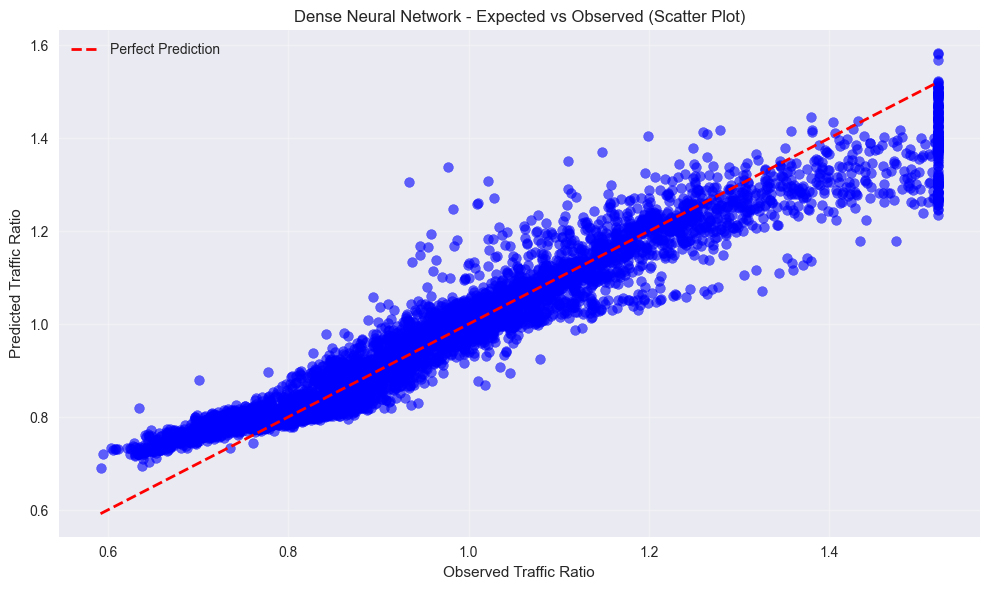

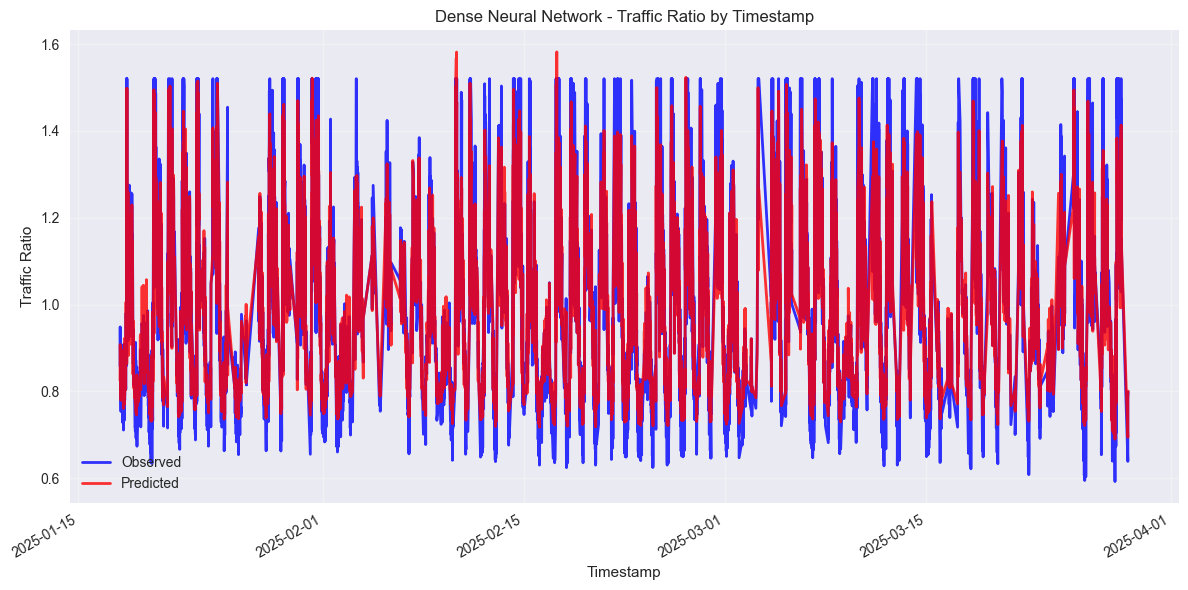

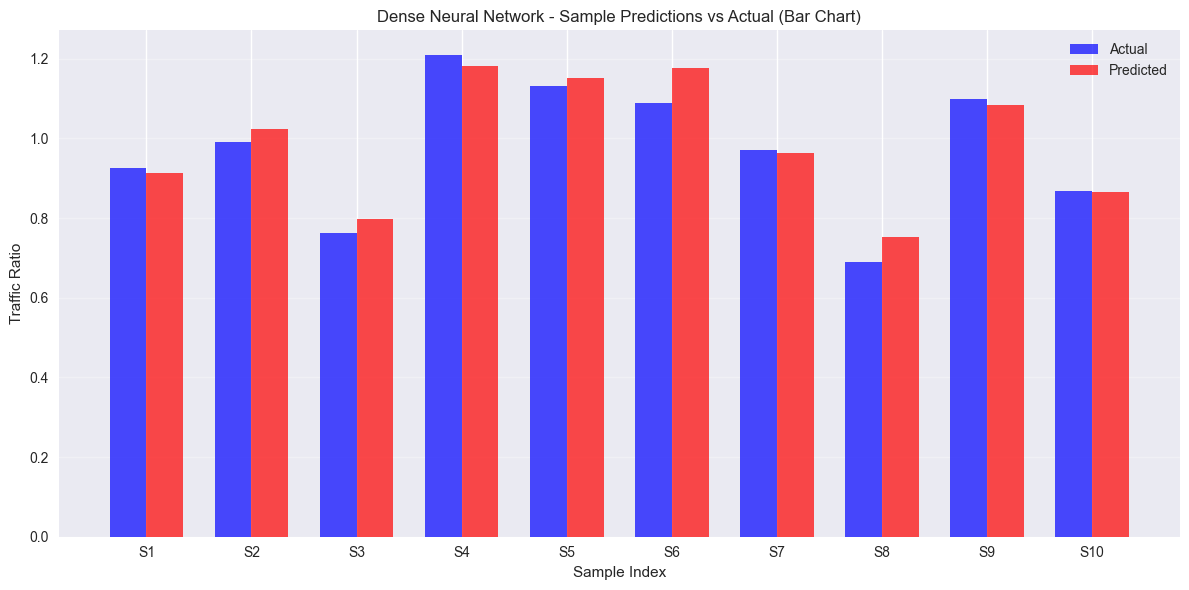


ADDITIONAL STATISTICS for Dense Neural Network (ORIGINAL SCALE):
--------------------------------------------------
Mean Squared Error (MSE) - Original Scale: 0.003575
Root Mean Squared Error (RMSE) - Original Scale: 0.059791
Mean Absolute Error (MAE) - Original Scale: 0.042043
R² Score - Original Scale: 0.918223
Mean Absolute Percentage Error (MAPE): 4.29%

Prediction Range Analysis (Original Scale):
Observed values - Min: 0.592026, Max: 1.520547
Predicted values - Min: 0.689856, Max: 1.582280
Prediction range coverage: 96.1%


In [51]:
# Use the saved original data for inverse transformation
analyze_model_performance_original(
    'Dense Neural Network', 
    dense_model, 
    X_test_scaled, 
    y_test, 
    n_samples=10,
    original_data=original_df,  
    target_column_name='traffic_ratio',
    timestamps=original_df.loc[y_test.index, 'timestamp']  # Use y_test.index instead
)


ANALYZING MODEL: Temporal CNN (ORIGINAL SCALE)
DEBUG INFO:
X_test shape: (5673, 15)
y_test shape: (5673,)
y_test type: <class 'pandas.core.series.Series'>
y_test index range: 7 to 28356
original_data shape: (28361, 30)
target column 'traffic_ratio' in original_data: True
timestamps shape: (5673,)
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
y_pred shape: (5673,)

Temporal CNN - Observed vs Predicted ORIGINAL VALUES (Sample of 10 predictions):
-----------------------------------------------------------------------------------------------
Index  Observed (Orig) Predicted (Orig) Difference   Abs Error    % Error   
-----------------------------------------------------------------------------------------------
169    1.182898        1.237499         -0.054601    0.054601     4.62      %
442    1.103855        1.307879         -0.204024    0.204024     18.48     %
2885   0.603137        0.766276         -0.163138    0.163138     27.05     %
1806   1.029475        1.188995         -0.159520    

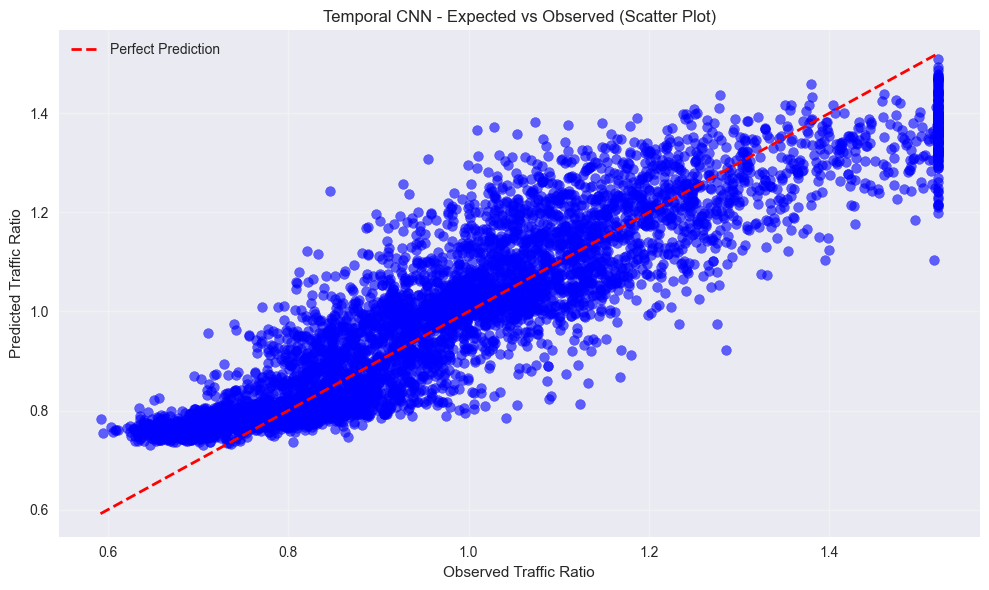

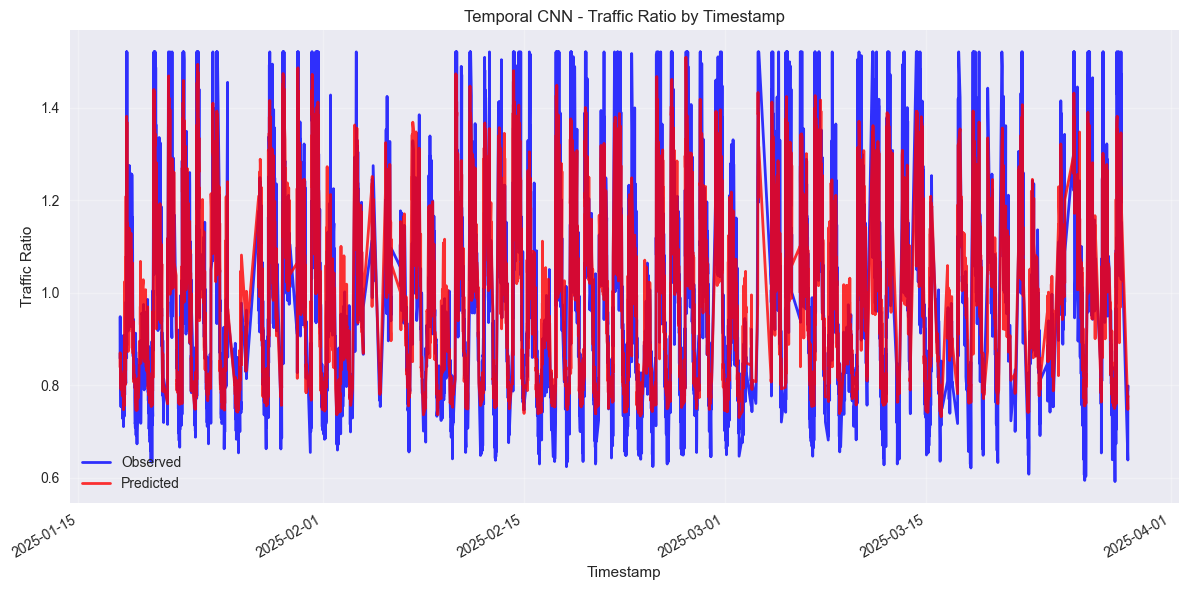

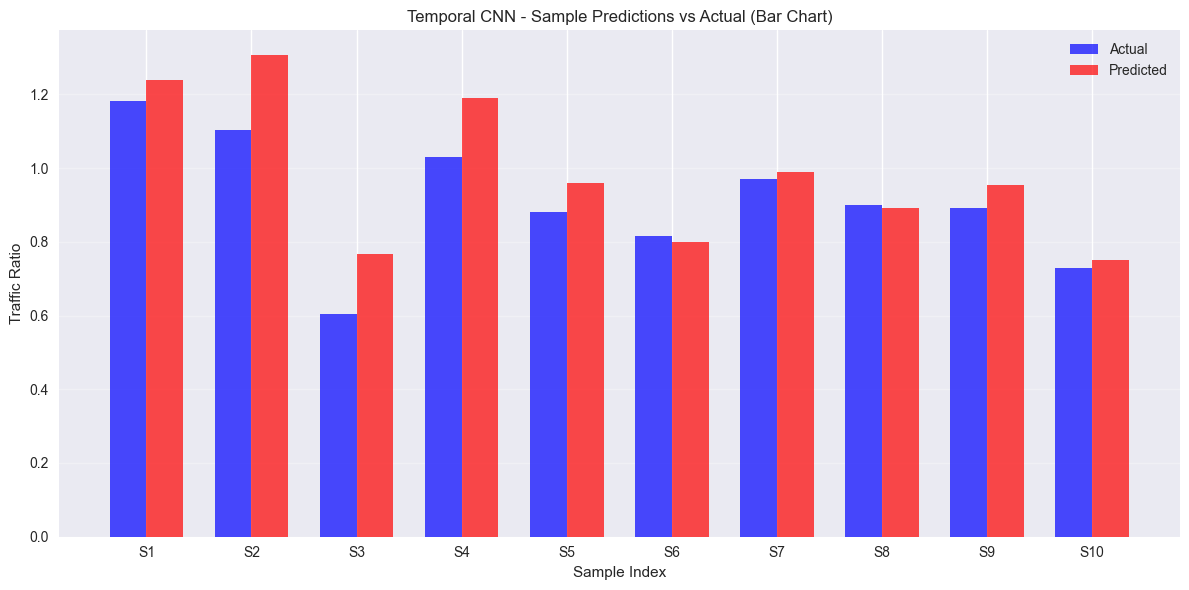


ADDITIONAL STATISTICS for Temporal CNN (ORIGINAL SCALE):
--------------------------------------------------
Mean Squared Error (MSE) - Original Scale: 0.008091
Root Mean Squared Error (RMSE) - Original Scale: 0.089952
Mean Absolute Error (MAE) - Original Scale: 0.068740
R² Score - Original Scale: 0.814910
Mean Absolute Percentage Error (MAPE): 7.00%

Prediction Range Analysis (Original Scale):
Observed values - Min: 0.592026, Max: 1.520547
Predicted values - Min: 0.730500, Max: 1.509086
Prediction range coverage: 83.9%


In [53]:
# Use the saved original data for inverse transformation
analyze_model_performance_original(
    'Temporal CNN', 
    tcnn_model, 
    X_test_scaled, 
    y_test, 
    n_samples=10,
    original_data=original_df,  
    target_column_name='traffic_ratio',
    timestamps=original_df.loc[y_test.index, 'timestamp']  # Use y_test.index instead
)


ANALYZING MODEL: Regularized Ensemble (ORIGINAL SCALE)
DEBUG INFO:
X_test shape: (5673, 15)
y_test shape: (5673,)
y_test type: <class 'pandas.core.series.Series'>
y_test index range: 7 to 28356
original_data shape: (28361, 30)
target column 'traffic_ratio' in original_data: True
timestamps shape: (5673,)
y_pred shape: (5673,)

Regularized Ensemble - Observed vs Predicted ORIGINAL VALUES (Sample of 10 predictions):
-----------------------------------------------------------------------------------------------
Index  Observed (Orig) Predicted (Orig) Difference   Abs Error    % Error   
-----------------------------------------------------------------------------------------------
103    0.953907        1.008992         -0.055085    0.055085     5.77      %
1545   1.276078        1.142599         0.133479     0.133479     10.46     %
4786   0.737154        0.774719         -0.037566    0.037566     5.10      %
2770   0.713700        0.778775         -0.065076    0.065076     9.12      %


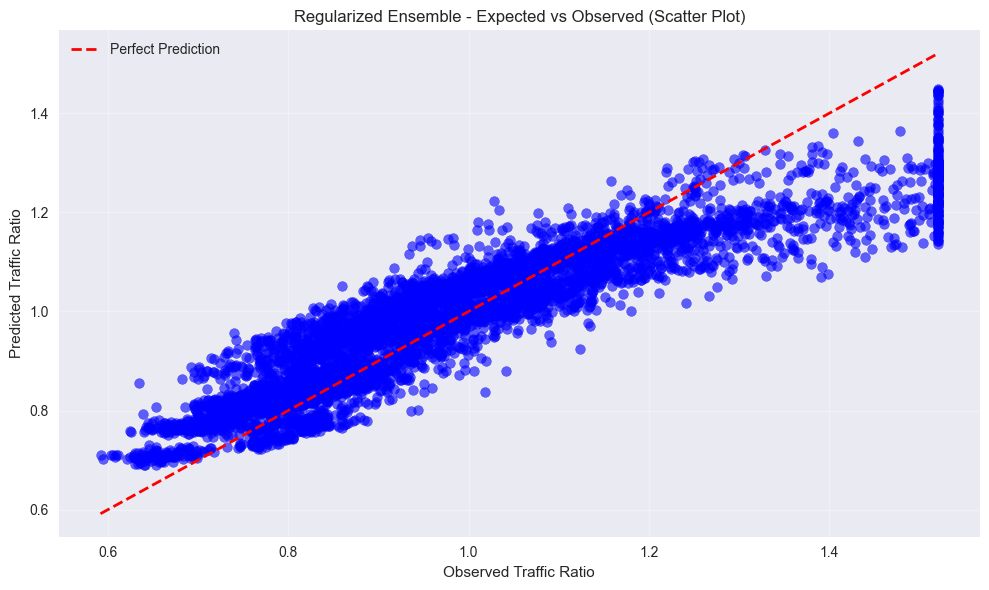

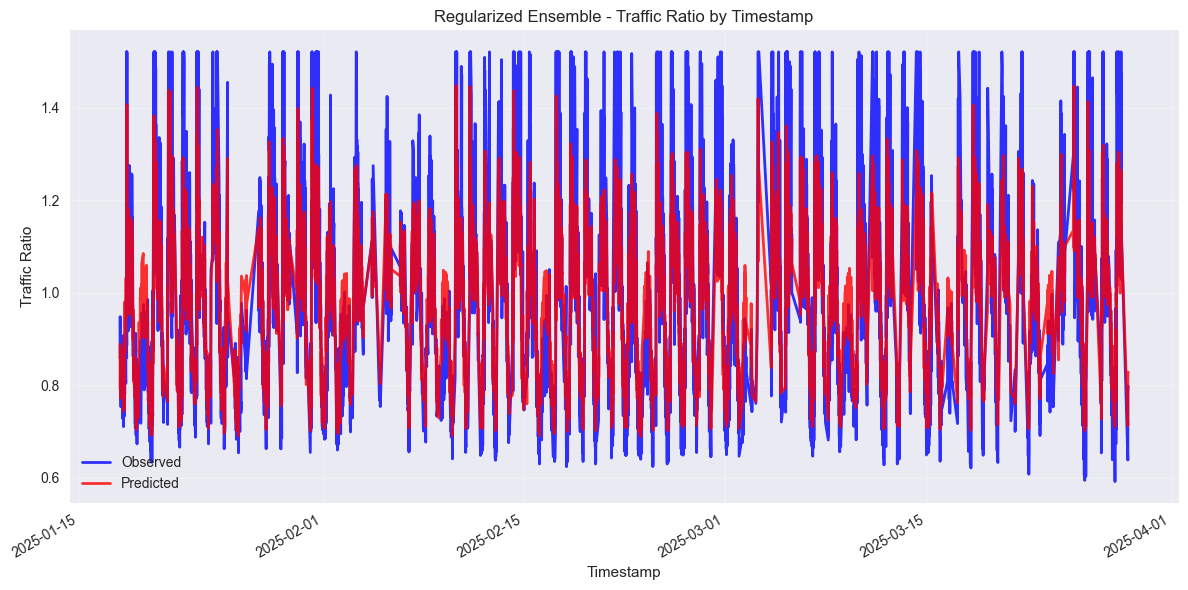

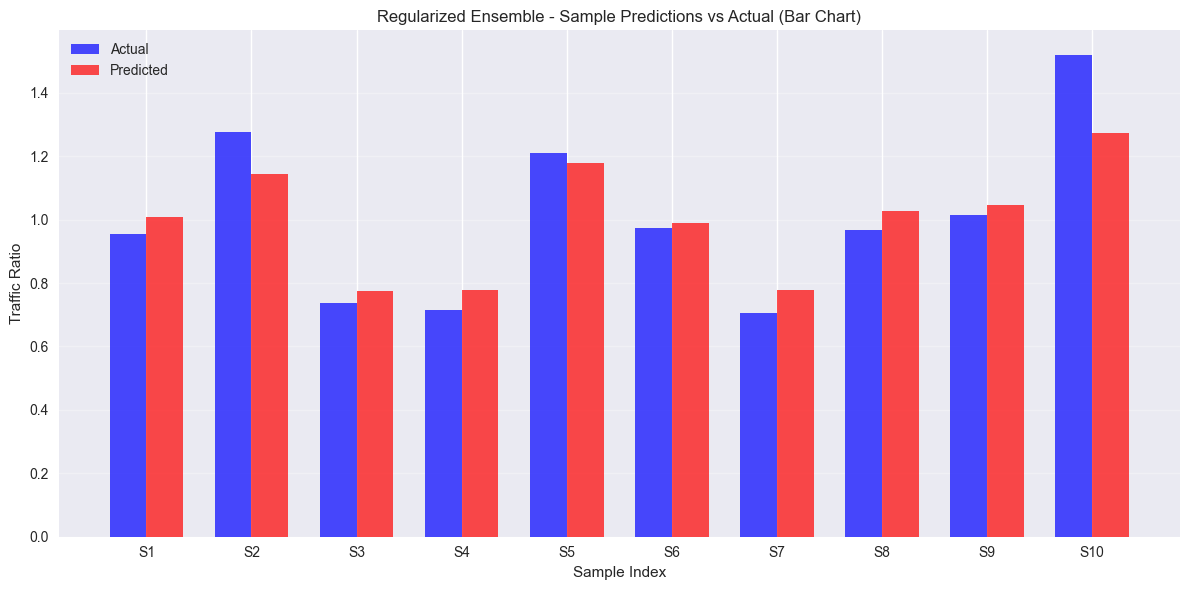


ADDITIONAL STATISTICS for Regularized Ensemble (ORIGINAL SCALE):
--------------------------------------------------
Mean Squared Error (MSE) - Original Scale: 0.008666
Root Mean Squared Error (RMSE) - Original Scale: 0.093090
Mean Absolute Error (MAE) - Original Scale: 0.068551
R² Score - Original Scale: 0.801770
Mean Absolute Percentage Error (MAPE): 6.84%

Prediction Range Analysis (Original Scale):
Observed values - Min: 0.592026, Max: 1.520547
Predicted values - Min: 0.689351, Max: 1.448421
Prediction range coverage: 81.8%


In [54]:
# Use the saved original data for inverse transformation
analyze_model_performance_original(
    'Regularized Ensemble', 
    ensemble_model, 
    X_test_scaled, 
    y_test, 
    n_samples=10,
    original_data=original_df,  
    target_column_name='traffic_ratio',
    timestamps=original_df.loc[y_test.index, 'timestamp']  # Use y_test.index instead
)

In [55]:
# Modified Observed vs Predicted Comparison with Original Values (SVR)
print("\n=== OBSERVED VS PREDICTED COMPARISON (ORIGINAL VALUES) ===")

def inverse_transform_target(y_normalized, target_scaler=None, target_column_name='traffic_ratio', 
                           original_data=None, preprocessor=None):
    """
    Inverse transform the normalized target values back to original scale
    
    Parameters:
    - y_normalized: normalized target values
    - target_scaler: if you have a separate scaler for target variable
    - target_column_name: name of the target column in original data
    - original_data: original dataframe before preprocessing
    - preprocessor: your TrafficDataPreprocessor instance
    """
    
    if target_scaler is not None:
        # If you have a dedicated target scaler
        return target_scaler.inverse_transform(y_normalized.reshape(-1, 1)).flatten()
    
    elif preprocessor is not None and hasattr(preprocessor, 'scaler'):
        # If the target was normalized with the main scaler
        try:
            # Get the feature names that were normalized
            feature_names = preprocessor.scaler.feature_names_in_
            if target_column_name in feature_names:
                # Find the index of the target column
                target_idx = list(feature_names).index(target_column_name)
                
                # Get the scale and mean for the target column
                scale = preprocessor.scaler.scale_[target_idx]
                mean = preprocessor.scaler.mean_[target_idx]
                
                # Inverse transform: original = (normalized * scale) + mean
                return (y_normalized * scale) + mean
            else:
                print(f"Warning: {target_column_name} not found in scaler features")
                return y_normalized
        except Exception as e:
            print(f"Error in inverse transform: {e}")
            return y_normalized
    
    elif original_data is not None and target_column_name in original_data.columns:
        # Calculate statistics from original data and manually inverse transform
        original_target = original_data[target_column_name]
        original_mean = original_target.mean()
        original_std = original_target.std()
        
        # Inverse standardization: original = (normalized * std) + mean
        return (y_normalized * original_std) + original_mean
    
    else:
        print("Warning: No inverse transformation method available. Returning normalized values.")
        return y_normalized

def display_observed_vs_predicted_original(model_name, y_true, y_pred, n_samples=10, 
                                         target_scaler=None, target_column_name='traffic_ratio',
                                         original_data=None, preprocessor=None, timestamps=None):
    """Display observed vs predicted values in ORIGINAL scale"""
    
    # Convert back to original scale
    y_true_original = inverse_transform_target(y_true, target_scaler, target_column_name, 
                                             original_data, preprocessor)
    y_pred_original = inverse_transform_target(y_pred, target_scaler, target_column_name, 
                                             original_data, preprocessor)
    
    # Convert to arrays for consistent indexing
    if hasattr(y_true_original, 'values'):
        y_true_original = y_true_original.values
    if hasattr(y_pred_original, 'values'):
        y_pred_original = y_pred_original.values
        
    # Select random samples - ensure we use valid indices
    max_idx = min(len(y_true_original), len(y_pred_original)) - 1
    n_samples = min(n_samples, max_idx + 1)
    indices = np.random.choice(max_idx + 1, n_samples, replace=False)
    
    print(f"\n{model_name} - Observed vs Predicted ORIGINAL VALUES (Sample of {n_samples} predictions):")
    print("-" * 95)
    print(f"{'Index':<6} {'Observed (Orig)':<15} {'Predicted (Orig)':<16} {'Difference':<12} {'Abs Error':<12} {'% Error':<10}")
    print("-" * 95)
    
    total_error = 0
    total_percent_error = 0
    
    for i, idx in enumerate(indices):
        observed_orig = y_true_original[idx]
        predicted_orig = y_pred_original[idx]
        difference = observed_orig - predicted_orig
        abs_error = abs(difference)
        percent_error = (abs_error / abs(observed_orig)) * 100 if abs(observed_orig) > 0 else 0
        
        total_error += abs_error
        total_percent_error += percent_error
        
        print(f"{idx:<6} {observed_orig:<15.6f} {predicted_orig:<16.6f} {difference:<12.6f} {abs_error:<12.6f} {percent_error:<10.2f}%")
    
    avg_error = total_error / n_samples
    avg_percent_error = total_percent_error / n_samples
    
    print("-" * 95)
    print(f"Average Absolute Error for these {n_samples} samples: {avg_error:.6f}")
    print(f"Average Percentage Error: {avg_percent_error:.2f}%")
    
    return indices, y_true_original, y_pred_original

def plot_scatter_observed_vs_predicted(model_name, y_true_orig, y_pred_orig):
    """Scatter plot for expected vs observed (all data)"""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true_orig, y_pred_orig, alpha=0.6, color='blue', s=50)
    plt.plot([y_true_orig.min(), y_true_orig.max()], [y_true_orig.min(), y_true_orig.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Observed Traffic Ratio')
    plt.ylabel('Predicted Traffic Ratio')
    plt.title(f'{model_name} - Expected vs Observed (Scatter Plot)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_timestamp_observed_vs_predicted(model_name, y_true_orig, y_pred_orig, timestamps):
    """Line chart for traffic ratio by timestamp"""
    plt.figure(figsize=(12, 6))
    
    # Ensure timestamps are in the right format and sorted
    if hasattr(timestamps, 'values'):
        timestamps = timestamps.values
        
    # If timestamps are not datetime objects, try to convert
    if not np.issubdtype(timestamps.dtype, np.datetime64):
        try:
            timestamps = pd.to_datetime(timestamps)
        except:
            print("Warning: Could not convert timestamps to datetime format. Using index instead.")
            timestamps = range(len(y_true_orig))
    
    # Sort by timestamp if possible
    if hasattr(timestamps, 'argsort'):
        sorted_indices = timestamps.argsort()
        sorted_timestamps = timestamps[sorted_indices]
        sorted_observed = y_true_orig[sorted_indices]
        sorted_predicted = y_pred_orig[sorted_indices]
    else:
        sorted_timestamps = timestamps
        sorted_observed = y_true_orig
        sorted_predicted = y_pred_orig
    
    plt.plot(sorted_timestamps, sorted_observed, 'b-', label='Observed', linewidth=2, alpha=0.8)
    plt.plot(sorted_timestamps, sorted_predicted, 'r-', label='Predicted', linewidth=2, alpha=0.8)
    
    # Format x-axis for timestamps if they are datetime objects
    if hasattr(sorted_timestamps, 'dtype') and np.issubdtype(sorted_timestamps.dtype, np.datetime64):
        plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
        plt.xlabel('Timestamp')
    else:
        plt.xlabel('Time Index')
        
    plt.ylabel('Traffic Ratio')
    plt.title(f'{model_name} - Traffic Ratio by Timestamp')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_bar_sample_predictions(model_name, y_true_orig, y_pred_orig, indices):
    """Bar chart for sample predictions vs actual"""
    plt.figure(figsize=(12, 6))
    sample_observed = y_true_orig[indices]
    sample_predicted = y_pred_orig[indices]
    
    x_pos = np.arange(len(indices))
    width = 0.35
    
    plt.bar(x_pos - width/2, sample_observed, width, label='Actual', color='blue', alpha=0.7)
    plt.bar(x_pos + width/2, sample_predicted, width, label='Predicted', color='red', alpha=0.7)
    
    plt.xlabel('Sample Index')
    plt.ylabel('Traffic Ratio')
    plt.title(f'{model_name} - Sample Predictions vs Actual (Bar Chart)')
    plt.legend()
    plt.xticks(x_pos, [f'S{i+1}' for i in range(len(indices))])
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

def analyze_model_performance_original(model_name, model, X_test, y_test, n_samples=10,
                                     target_scaler=None, target_column_name='traffic_ratio',
                                     original_data=None, preprocessor=None, timestamps=None):
    """Complete analysis of model performance with ORIGINAL VALUES - SIMPLIFIED"""
    
    print(f"\n{'='*70}")
    print(f"ANALYZING MODEL: {model_name} (ORIGINAL SCALE)")
    print(f"{'='*70}")
    
    # Debug information
    print(f"DEBUG INFO:")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"y_test type: {type(y_test)}")
    if hasattr(y_test, 'index'):
        print(f"y_test index range: {y_test.index.min()} to {y_test.index.max()}")
    if original_data is not None:
        print(f"original_data shape: {original_data.shape}")
        print(f"target column '{target_column_name}' in original_data: {target_column_name in original_data.columns}")
    if timestamps is not None:
        print(f"timestamps shape: {timestamps.shape if hasattr(timestamps, 'shape') else len(timestamps)}")
    
    # Make predictions
    if hasattr(model, 'predict'):
        if 'Neural Network' in model_name or 'CNN' in model_name:
            y_pred = model.predict(X_test).flatten()
        else:
            y_pred = model.predict(X_test)
    else:
        print(f"Error: Model {model_name} does not have predict method")
        return
    
    print(f"y_pred shape: {y_pred.shape}")
    
    # Display numerical comparison in original scale
    try:
        indices, y_true_orig, y_pred_orig = display_observed_vs_predicted_original(
            model_name, y_test, y_pred, n_samples, target_scaler, 
            target_column_name, original_data, preprocessor, timestamps
        )
    except Exception as e:
        print(f"Error in display function: {e}")
        print("Attempting with smaller sample size...")
        try:
            indices, y_true_orig, y_pred_orig = display_observed_vs_predicted_original(
                model_name, y_test, y_pred, min(5, len(y_test)), target_scaler, 
                target_column_name, original_data, preprocessor, timestamps
            )
        except Exception as e2:
            print(f"Error even with smaller sample: {e2}")
            return
    
    # Create SIMPLIFIED visualizations with original values
    plot_scatter_observed_vs_predicted(model_name, y_true_orig, y_pred_orig)
    
    # Use timestamp-based line chart if timestamps are provided
    if timestamps is not None:
        plot_timestamp_observed_vs_predicted(model_name, y_true_orig, y_pred_orig, timestamps)
    else:
        print("Warning: No timestamps provided. Using default line chart.")
        # Create a simple line chart without timestamps
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(y_true_orig)), y_true_orig, 'b-', label='Observed', linewidth=2, alpha=0.8)
        plt.plot(range(len(y_pred_orig)), y_pred_orig, 'r-', label='Predicted', linewidth=2, alpha=0.8)
        plt.xlabel('Data Points')
        plt.ylabel('Traffic Ratio')
        plt.title(f'{model_name} - Expected vs Observed (Line Chart)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    plot_bar_sample_predictions(model_name, y_true_orig, y_pred_orig, indices)
    
    # Additional statistics in original scale
    print(f"\nADDITIONAL STATISTICS for {model_name} (ORIGINAL SCALE):")
    print("-" * 50)
    
    # Calculate overall metrics in original scale
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse_orig = mean_squared_error(y_true_orig, y_pred_orig)
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    r2_orig = r2_score(y_true_orig, y_pred_orig)
    rmse_orig = np.sqrt(mse_orig)
    
    print(f"Mean Squared Error (MSE) - Original Scale: {mse_orig:.6f}")
    print(f"Root Mean Squared Error (RMSE) - Original Scale: {rmse_orig:.6f}")
    print(f"Mean Absolute Error (MAE) - Original Scale: {mae_orig:.6f}")
    print(f"R² Score - Original Scale: {r2_orig:.6f}")
    
    # Calculate percentage-based metrics
    mean_percent_error = np.mean([abs(t - p) / abs(t) * 100 if abs(t) > 0 else 0 
                                 for t, p in zip(y_true_orig, y_pred_orig)])
    print(f"Mean Absolute Percentage Error (MAPE): {mean_percent_error:.2f}%")
    
    # Prediction range analysis in original scale
    print(f"\nPrediction Range Analysis (Original Scale):")
    print(f"Observed values - Min: {y_true_orig.min():.6f}, Max: {y_true_orig.max():.6f}")
    print(f"Predicted values - Min: {y_pred_orig.min():.6f}, Max: {y_pred_orig.max():.6f}")
    print(f"Prediction range coverage: {(y_pred_orig.max() - y_pred_orig.min()) / (y_true_orig.max() - y_true_orig.min()) * 100:.1f}%")

# Usage example:
# analyze_model_performance_original(
#     "Support Vector Regression", svr_model, X_test_scaled, y_test, n_samples=10,
#     original_data=original_df, target_column_name='traffic_ratio',
#     timestamps=original_df.loc[X_test.index, 'timestamp']
# )


=== OBSERVED VS PREDICTED COMPARISON (ORIGINAL VALUES) ===



ANALYZING MODEL: Support Vector Regression (ORIGINAL SCALE)
DEBUG INFO:
X_test shape: (5673, 15)
y_test shape: (5673,)
y_test type: <class 'pandas.core.series.Series'>
y_test index range: 7 to 28356
original_data shape: (28361, 30)
target column 'traffic_ratio' in original_data: True
timestamps shape: (5673,)
y_pred shape: (5673,)

Support Vector Regression - Observed vs Predicted ORIGINAL VALUES (Sample of 10 predictions):
-----------------------------------------------------------------------------------------------
Index  Observed (Orig) Predicted (Orig) Difference   Abs Error    % Error   
-----------------------------------------------------------------------------------------------
1582   0.823751        0.786498         0.037254     0.037254     4.52      %
3863   1.003892        0.930669         0.073223     0.073223     7.29      %
1907   1.119362        1.115254         0.004108     0.004108     0.37      %
4792   1.024882        1.172418         -0.147536    0.147536     14

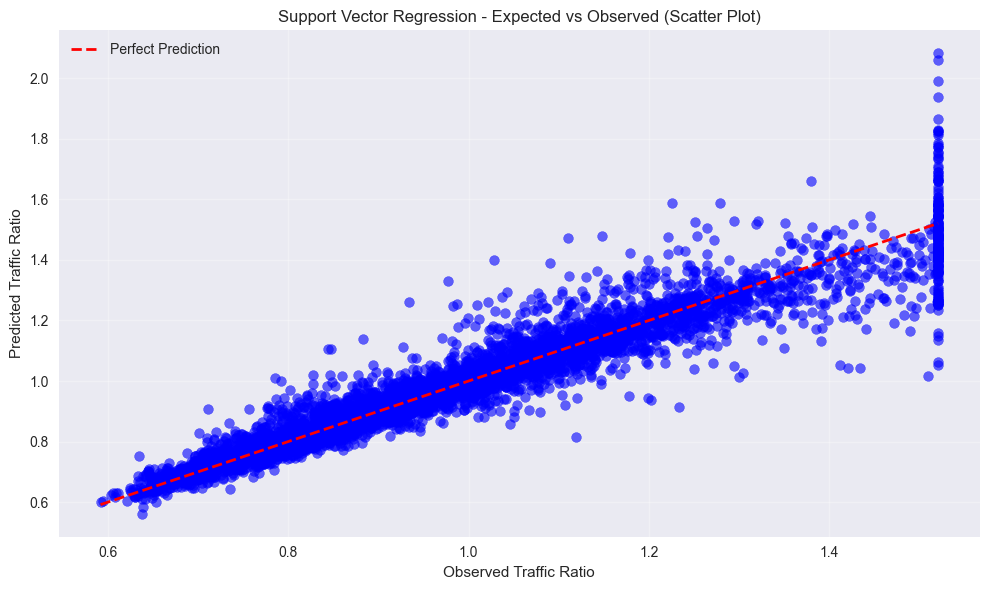

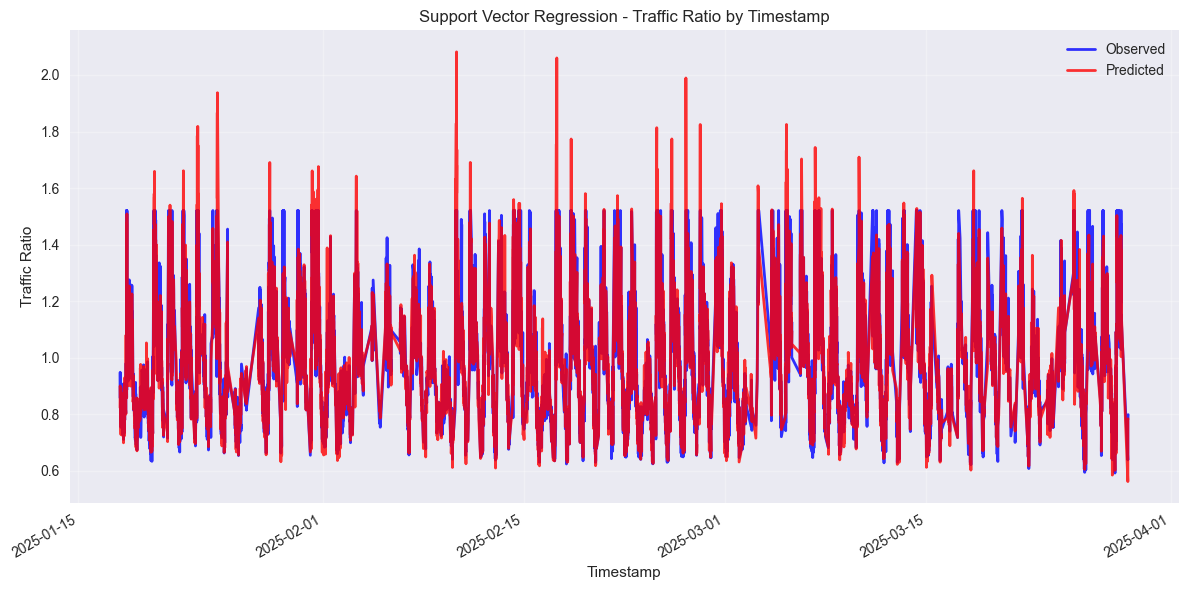

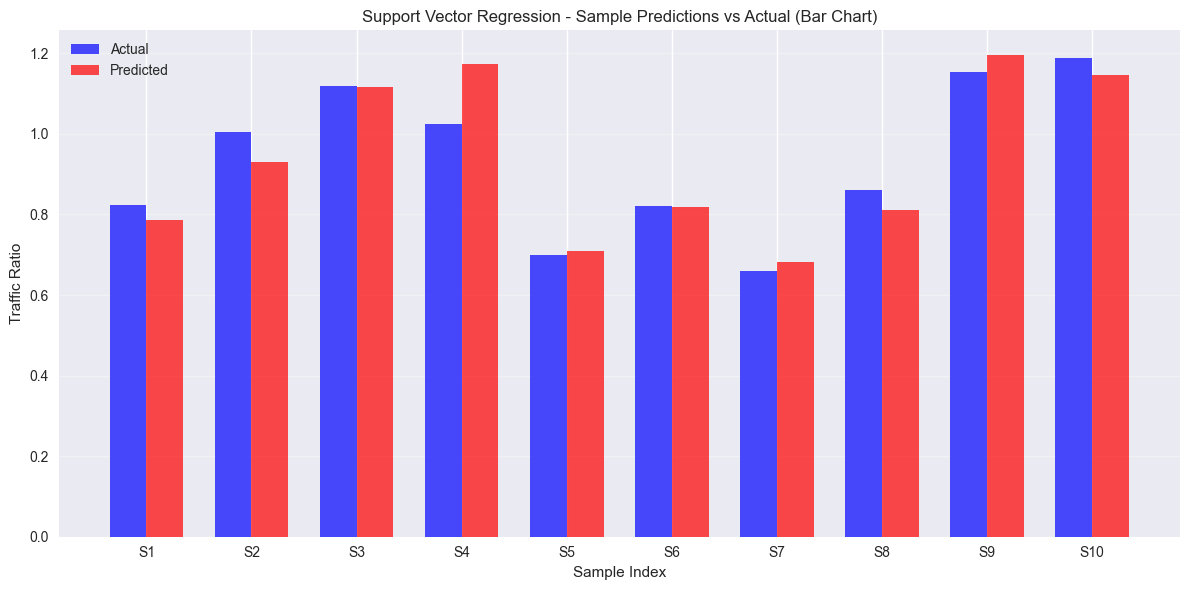


ADDITIONAL STATISTICS for Support Vector Regression (ORIGINAL SCALE):
--------------------------------------------------
Mean Squared Error (MSE) - Original Scale: 0.004030
Root Mean Squared Error (RMSE) - Original Scale: 0.063484
Mean Absolute Error (MAE) - Original Scale: 0.040162
R² Score - Original Scale: 0.907809
Mean Absolute Percentage Error (MAPE): 3.89%

Prediction Range Analysis (Original Scale):
Observed values - Min: 0.592026, Max: 1.520547
Predicted values - Min: 0.561973, Max: 2.081561
Prediction range coverage: 163.7%


In [56]:
analyze_model_performance_original(
    "Support Vector Regression", 
    svr_model, 
    X_test_scaled, 
    y_test, 
    n_samples=10,
    original_data=original_df, 
    target_column_name='traffic_ratio',
    timestamps=original_df.loc[X_test.index, 'timestamp']
)

In [57]:
# First, let's check the dimensions of your data
print("=== DATA DIMENSION ANALYSIS ===")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"X_test_scaled total elements: {X_test_scaled.size}")
print(f"y_test shape: {y_test.shape}")

# Calculate what the correct reshape should be
if len(X_test_scaled.shape) == 2:
    n_samples, n_features = X_test_scaled.shape
    print(f"Number of samples: {n_samples}")
    print(f"Number of features: {n_features}")
    
    # For LSTM, we need (samples, timesteps, features)
    # Since you have 2D data, we'll add a timestep dimension
    X_test_lstm = X_test_scaled.reshape((n_samples, 1, n_features))
    print(f"Correct LSTM reshape: {X_test_lstm.shape}")
else:
    print("X_test_scaled is not 2D - please check your data preprocessing")

# Enhanced analysis function that handles original scale predictions
def analyze_model_performance_original(model_name, model, X_test_2d, y_test, n_samples=10, 
                                     original_data=None, target_column_name=None, 
                                     scaler_y=None, timestamps=None):
    """
    Complete analysis of LSTM model performance with original scale conversion
    """
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    # Ensure y_test is 1D
    y_test = np.asarray(y_test).flatten()
    
    # Check input dimensions
    print(f"\n{'='*60}")
    print(f"ANALYZING MODEL: {model_name}")
    print(f"{'='*60}")
    print(f"Input X_test shape: {X_test_2d.shape}")
    print(f"Input y_test shape: {y_test.shape}")
    if timestamps is not None:
        print(f"Timestamps shape: {timestamps.shape if hasattr(timestamps, 'shape') else len(timestamps)}")
    
    # Reshape for LSTM if needed
    if len(X_test_2d.shape) == 2:
        n_samples_data, n_features = X_test_2d.shape
        X_test_lstm = X_test_2d.reshape((n_samples_data, 1, n_features))
        print(f"Reshaped for LSTM: {X_test_lstm.shape}")
    elif len(X_test_2d.shape) == 3:
        X_test_lstm = X_test_2d
        print(f"Already 3D: {X_test_lstm.shape}")
    else:
        raise ValueError(f"Unexpected input shape: {X_test_2d.shape}")
    
    # Make predictions
    try:
        y_pred = model.predict(X_test_lstm).flatten()
        print(f"Predictions shape: {y_pred.shape}")
    except Exception as e:
        print(f"Error making predictions: {e}")
        return
    
    # Verify shapes match
    if len(y_test) != len(y_pred):
        print(f"Warning: y_test ({len(y_test)}) and y_pred ({len(y_pred)}) have different lengths")
        min_len = min(len(y_test), len(y_pred))
        y_test = y_test[:min_len]
        y_pred = y_pred[:min_len]
        print(f"Trimmed both to length: {min_len}")
    
    # Convert to original scale
    y_true_orig, y_pred_orig = convert_to_original_scale(
        y_test, y_pred, original_data, target_column_name, scaler_y
    )
    
    # Display observed vs predicted (scaled and original)
    indices = display_observed_vs_predicted_original(
        model_name, y_test, y_pred, y_true_orig, y_pred_orig, n_samples
    )
    
    # Calculate metrics for scaled data
    mse_scaled = mean_squared_error(y_test, y_pred)
    mae_scaled = mean_absolute_error(y_test, y_pred)
    r2_scaled = r2_score(y_test, y_pred)
    rmse_scaled = np.sqrt(mse_scaled)
    
    # Calculate metrics for original scale
    mse_orig = mean_squared_error(y_true_orig, y_pred_orig)
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    r2_orig = r2_score(y_true_orig, y_pred_orig)
    rmse_orig = np.sqrt(mse_orig)
    
    print(f"\nPERFORMANCE METRICS for {model_name} (Scaled Data):")
    print("-" * 50)
    print(f"Mean Squared Error (MSE): {mse_scaled:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_scaled:.6f}")
    print(f"Mean Absolute Error (MAE): {mae_scaled:.6f}")
    print(f"R² Score: {r2_scaled:.6f}")
    
    print(f"\nPERFORMANCE METRICS for {model_name} (Original Scale):")
    print("-" * 50)
    print(f"Mean Squared Error (MSE): {mse_orig:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_orig:.6f}")
    print(f"Mean Absolute Error (MAE): {mae_orig:.6f}")
    print(f"R² Score: {r2_orig:.6f}")
    
    # Prediction range analysis
    print(f"\nPrediction Range Analysis (Original Scale):")
    print(f"Observed values - Min: {y_true_orig.min():.6f}, Max: {y_true_orig.max():.6f}")
    print(f"Predicted values - Min: {y_pred_orig.min():.6f}, Max: {y_pred_orig.max():.6f}")
    print(f"Prediction range coverage: {(y_pred_orig.max() - y_pred_orig.min()) / (y_true_orig.max() - y_true_orig.min()) * 100:.1f}%")
    
    # Create simplified visualizations
    plot_scatter_observed_vs_predicted(model_name, y_true_orig, y_pred_orig)
    
    # Use timestamp-based line chart if timestamps are provided
    if timestamps is not None:
        plot_timestamp_observed_vs_predicted(model_name, y_true_orig, y_pred_orig, timestamps[:len(y_true_orig)])
    else:
        print("Warning: No timestamps provided. Using default line chart.")
        # Create a simple line chart without timestamps
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(y_true_orig)), y_true_orig, 'b-', label='Observed', linewidth=2, alpha=0.8)
        plt.plot(range(len(y_pred_orig)), y_pred_orig, 'r-', label='Predicted', linewidth=2, alpha=0.8)
        plt.xlabel('Data Points')
        plt.ylabel('Traffic Ratio')
        plt.title(f'{model_name} - Expected vs Observed (Line Chart)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    plot_bar_sample_predictions(model_name, y_true_orig, y_pred_orig, indices)
    
    return y_pred, y_pred_orig

def convert_to_original_scale(y_test, y_pred, original_data=None, target_column_name=None, scaler_y=None):
    """
    Convert scaled predictions back to original scale
    """
    import numpy as np
    
    if scaler_y is not None:
        # If we have the scaler used for the target variable
        print("Using provided scaler to convert to original scale...")
        y_true_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    elif original_data is not None and target_column_name is not None:
        # Calculate statistics from original data
        print("Using original data statistics to convert to original scale...")
        original_values = original_data[target_column_name].values
        orig_mean = np.mean(original_values)
        orig_std = np.std(original_values)
        
        # Assuming standard scaling was used: (x - mean) / std
        y_true_orig = (y_test * orig_std) + orig_mean
        y_pred_orig = (y_pred * orig_std) + orig_mean
    else:
        # If no conversion method available, use scaled values
        print("Warning: No method available to convert to original scale. Using scaled values...")
        y_true_orig = y_test.copy()
        y_pred_orig = y_pred.copy()
    
    return y_true_orig, y_pred_orig

def display_observed_vs_predicted_original(model_name, y_true_scaled, y_pred_scaled, 
                                         y_true_orig, y_pred_orig, n_samples=10):
    """Display observed vs predicted values in both scaled and original format"""
    import numpy as np
    
    # Force 1D arrays
    y_true_scaled = np.asarray(y_true_scaled).flatten()
    y_pred_scaled = np.asarray(y_pred_scaled).flatten()
    y_true_orig = np.asarray(y_true_orig).flatten()
    y_pred_orig = np.asarray(y_pred_orig).flatten()
    
    # Select random samples
    indices = np.random.choice(len(y_true_scaled), n_samples, replace=False)
    
    print(f"\n{model_name} - Observed vs Predicted (Sample of {n_samples} predictions):")
    print("="*120)
    print("SCALED VALUES:")
    print("-"*60)
    print(f"{'Index':<6} {'Observed':<12} {'Predicted':<12} {'Difference':<12} {'Abs Error':<12}")
    print("-"*60)
    
    total_error_scaled = 0
    for idx in indices:
        observed = float(y_true_scaled[idx])
        predicted = float(y_pred_scaled[idx])
        difference = observed - predicted
        abs_error = abs(difference)
        total_error_scaled += abs_error
        
        print(f"{idx:<6} {observed:<12.6f} {predicted:<12.6f} {difference:<12.6f} {abs_error:<12.6f}")
    
    avg_error_scaled = total_error_scaled / n_samples
    print("-"*60)
    print(f"Average Absolute Error (Scaled): {avg_error_scaled:.6f}")
    
    print("\nORIGINAL SCALE VALUES:")
    print("-"*60)
    print(f"{'Index':<6} {'Observed':<12} {'Predicted':<12} {'Difference':<12} {'Abs Error':<12}")
    print("-"*60)
    
    total_error_orig = 0
    for idx in indices:
        observed = float(y_true_orig[idx])
        predicted = float(y_pred_orig[idx])
        difference = observed - predicted
        abs_error = abs(difference)
        total_error_orig += abs_error
        
        print(f"{idx:<6} {observed:<12.6f} {predicted:<12.6f} {difference:<12.6f} {abs_error:<12.6f}")
    
    avg_error_orig = total_error_orig / n_samples
    print("-"*60)
    print(f"Average Absolute Error (Original): {avg_error_orig:.6f}")
    
    return indices

def plot_scatter_observed_vs_predicted(model_name, y_true_orig, y_pred_orig):
    """Scatter plot for expected vs observed (all data)"""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true_orig, y_pred_orig, alpha=0.6, color='blue', s=50)
    plt.plot([y_true_orig.min(), y_true_orig.max()], [y_true_orig.min(), y_true_orig.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Observed Traffic Ratio')
    plt.ylabel('Predicted Traffic Ratio')
    plt.title(f'{model_name} - Expected vs Observed (Scatter Plot)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_timestamp_observed_vs_predicted(model_name, y_true_orig, y_pred_orig, timestamps):
    """Line chart for traffic ratio by timestamp"""
    plt.figure(figsize=(12, 6))
    
    # Ensure timestamps are in the right format and sorted
    if hasattr(timestamps, 'values'):
        timestamps = timestamps.values
        
    # If timestamps are not datetime objects, try to convert
    if not np.issubdtype(timestamps.dtype, np.datetime64):
        try:
            timestamps = pd.to_datetime(timestamps)
        except:
            print("Warning: Could not convert timestamps to datetime format. Using index instead.")
            timestamps = range(len(y_true_orig))
    
    # Sort by timestamp if possible
    if hasattr(timestamps, 'argsort'):
        sorted_indices = timestamps.argsort()
        sorted_timestamps = timestamps[sorted_indices]
        sorted_observed = y_true_orig[sorted_indices]
        sorted_predicted = y_pred_orig[sorted_indices]
    else:
        sorted_timestamps = timestamps
        sorted_observed = y_true_orig
        sorted_predicted = y_pred_orig
    
    plt.plot(sorted_timestamps, sorted_observed, 'b-', label='Observed', linewidth=2, alpha=0.8)
    plt.plot(sorted_timestamps, sorted_predicted, 'r-', label='Predicted', linewidth=2, alpha=0.8)
    
    # Format x-axis for timestamps if they are datetime objects
    if hasattr(sorted_timestamps, 'dtype') and np.issubdtype(sorted_timestamps.dtype, np.datetime64):
        plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
        plt.xlabel('Timestamp')
    else:
        plt.xlabel('Time Index')
        
    plt.ylabel('Traffic Ratio')
    plt.title(f'{model_name} - Traffic Ratio by Timestamp')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_bar_sample_predictions(model_name, y_true_orig, y_pred_orig, indices):
    """Bar chart for sample predictions vs actual"""
    plt.figure(figsize=(12, 6))
    sample_observed = y_true_orig[indices]
    sample_predicted = y_pred_orig[indices]
    
    x_pos = np.arange(len(indices))
    width = 0.35
    
    plt.bar(x_pos - width/2, sample_observed, width, label='Actual', color='blue', alpha=0.7)
    plt.bar(x_pos + width/2, sample_predicted, width, label='Predicted', color='red', alpha=0.7)
    
    plt.xlabel('Sample Index')
    plt.ylabel('Traffic Ratio')
    plt.title(f'{model_name} - Sample Predictions vs Actual (Bar Chart)')
    plt.legend()
    plt.xticks(x_pos, [f'S{i+1}' for i in range(len(indices))])
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

# Legacy function for backward compatibility
def analyze_lstm_model_performance(model_name, model, X_test_2d, y_test, n_samples=10, timestamps=None):
    """
    Legacy function - redirects to the new enhanced version
    """
    print("Note: Using legacy function. Consider using 'analyze_model_performance_original' for enhanced features.")
    return analyze_model_performance_original(model_name, model, X_test_2d, y_test, n_samples, timestamps=timestamps)

=== DATA DIMENSION ANALYSIS ===
X_test_scaled shape: (5673, 15)
X_test_scaled total elements: 85095
y_test shape: (5673,)
Number of samples: 5673
Number of features: 15
Correct LSTM reshape: (5673, 1, 15)



ANALYZING MODEL: LSTM Model
Input X_test shape: (5673, 15)
Input y_test shape: (5673,)
Timestamps shape: (5673,)
Reshaped for LSTM: (5673, 1, 15)
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions shape: (5673,)
Using original data statistics to convert to original scale...

LSTM Model - Observed vs Predicted (Sample of 10 predictions):
SCALED VALUES:
------------------------------------------------------------
Index  Observed     Predicted    Difference   Abs Error   
------------------------------------------------------------
4579   -0.444056    0.260812     -0.704867    0.704867    
3801   -0.807713    -0.338759    -0.468954    0.468954    
3959   -0.002411    0.520720     -0.523130    0.523130    
1003   -0.762499    -0.581717    -0.180781    0.180781    
140    -1.578409    -0.732949    -0.845459    0.845459    
4883   -0.176530    0.310553     -0.487083    0.487083    
3980   -0.196913    0.527556     -0.724469    0.724469    
2177   -0.302141    -0.640536    0.338395     0.3

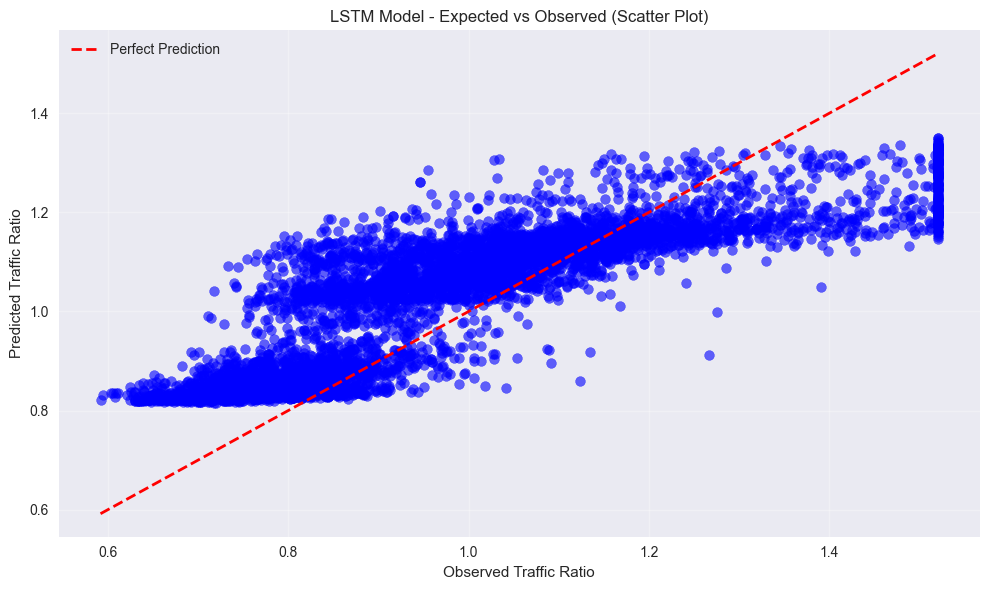

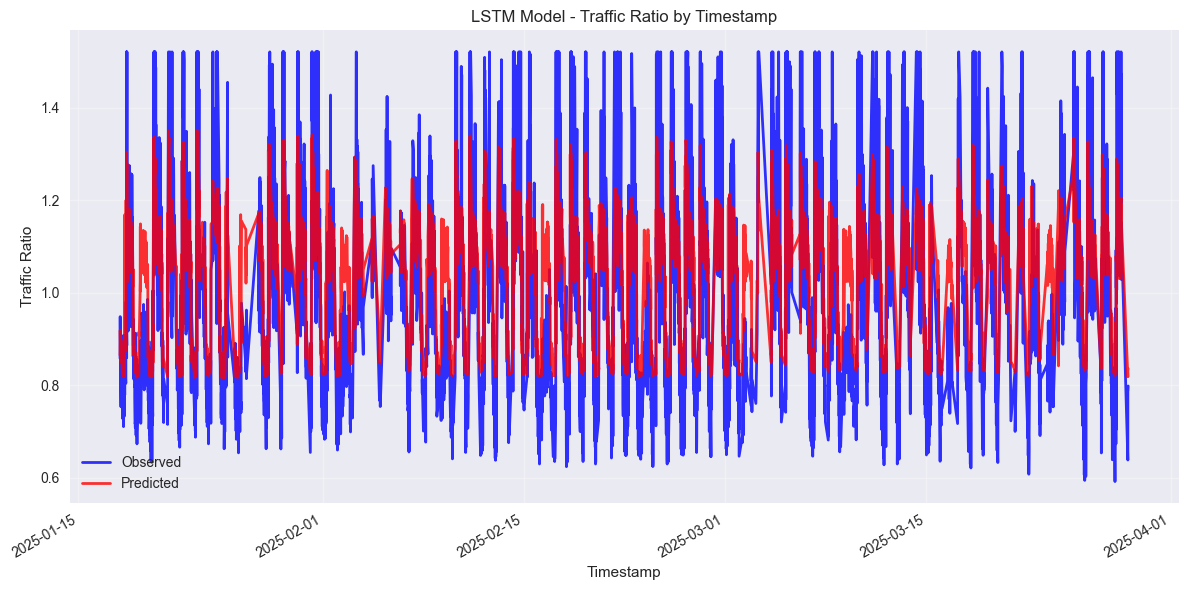

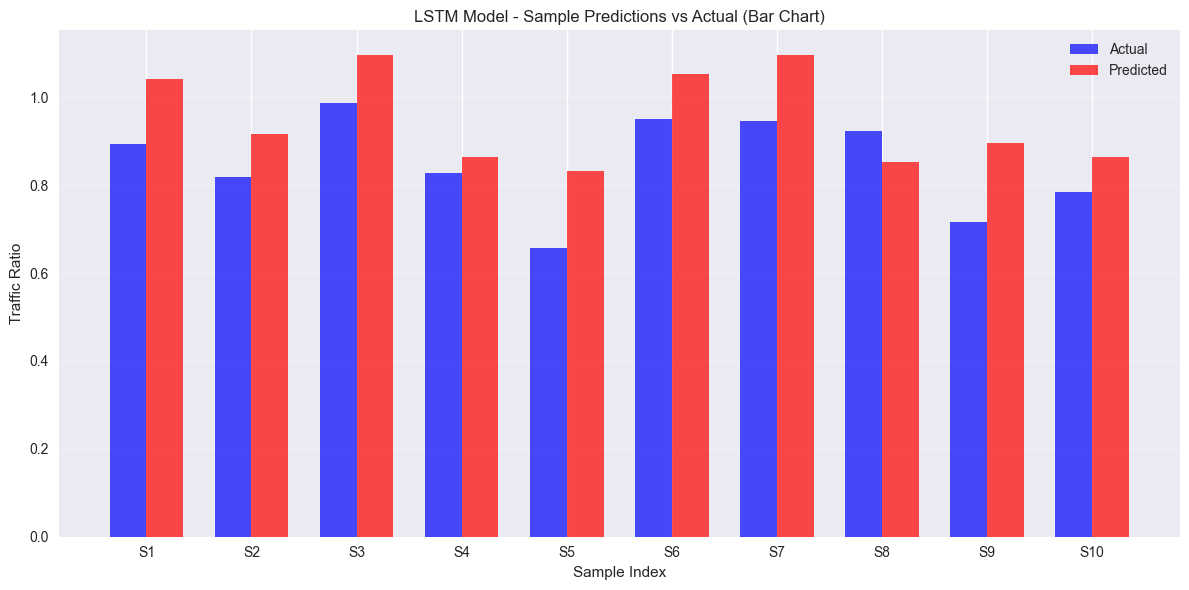

(array([-0.76766634, -0.6214133 ,  0.68374276, ..., -0.7587461 ,
        -0.66320246, -0.7049164 ], dtype=float32),
 array([0.82597107, 0.85660833, 1.1300138 , ..., 0.82783973, 0.8478543 ,
        0.839116  ], dtype=float32))

In [58]:
analyze_model_performance_original(
    "LSTM Model", 
    lstm_model, 
    X_test_scaled, 
    y_test, 
    n_samples=10,
    original_data=original_df, 
    target_column_name='traffic_ratio',
    timestamps=original_df.loc[X_test.index, 'timestamp']
)

In [ ]:
#  Save All Models and Data Files
print("\n=== SAVING MODELS AND DATA FILES ===")

import os
import pickle
from datetime import datetime

# Create a directory for saved models if it doesn't exist
save_directory = '/Users/user/Desktop/TrafficNG/saved_models/'
os.makedirs(save_directory, exist_ok=True)

# Update file paths to use the save directory
def get_save_path(filename):
    return os.path.join(save_directory, filename)

print(f"Saving all files to: {save_directory}")

# 1. Save processed data as pickle
try:
    processed_data_path = get_save_path('processed_data.pkl')
    with open(processed_data_path, 'wb') as f:
        pickle.dump(df, f)
    print(f"✅ Processed data saved to: {processed_data_path}")
    print(f"   Shape: {df.shape}")
except Exception as e:
    print(f"❌ Error saving processed data: {e}")

# 2. Save original data backup as CSV
try:
    original_backup_path = get_save_path('original_data_backup.csv')
    original_df.to_csv(original_backup_path, index=False)
    print(f"✅ Original data backup saved to: {original_backup_path}")
    print(f"   Shape: {original_df.shape}")
except Exception as e:
    print(f"❌ Error saving original data backup: {e}")

# 3. Save Dense Neural Network model
try:
    dense_model_path = get_save_path('dense_model.h5')
    dense_model.save(dense_model_path)
    print(f"✅ Dense model saved to: {dense_model_path}")
except Exception as e:
    print(f"❌ Error saving dense model: {e}")

# 4. Save TCNN model
try:
    tcnn_model_path = get_save_path('tcnn_model.h5')
    tcnn_model.save(tcnn_model_path)
    print(f"✅ TCNN model saved to: {tcnn_model_path}")
except Exception as e:
    print(f"❌ Error saving TCNN model: {e}")

# 5. Save LSTM model
try:
    lstm_model_path = get_save_path('lstm_model.h5')
    lstm_model.save(lstm_model_path)
    print(f"✅ LSTM model saved to: {lstm_model_path}")
except Exception as e:
    print(f"❌ Error saving LSTM model: {e}")

# 6. Save SVR model
try:
    svr_model_path = get_save_path('svr_model.pkl')
    with open(svr_model_path, 'wb') as f:
        pickle.dump(svr_model, f)
    print(f"✅ SVR model saved to: {svr_model_path}")
except Exception as e:
    print(f"❌ Error saving SVR model: {e}")

# 7. Save scaler
try:
    scaler_path = get_save_path('scaler.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(pipeline.scaler, f)
    print(f"✅ Scaler saved to: {scaler_path}")
except Exception as e:
    print(f"❌ Error saving scaler: {e}")

# 8. Save label encoders
try:
    label_encoders_path = get_save_path('label_encoders.pkl')
    with open(label_encoders_path, 'wb') as f:
        pickle.dump(pipeline.label_encoders, f)
    print(f"✅ Label encoders saved to: {label_encoders_path}")
    print(f"   Number of encoders: {len(pipeline.label_encoders)}")
except Exception as e:
    print(f"❌ Error saving label encoders: {e}")

# 9. Save model performance comparison
try:
    performance_path = get_save_path('model_performance_comparison.csv')
    comparison_df.to_csv(performance_path, index=False)
    print(f"✅ Model performance comparison saved to: {performance_path}")
except Exception as e:
    print(f"❌ Error saving model performance: {e}")

# 10. Save model metadata and information
try:
    metadata = {
        'save_timestamp': datetime.now().isoformat(),
        'feature_names': feature_names,
        'best_model': best_model_name,
        'model_performances': pipeline.model_performances,
        'data_shapes': {
            'original_data': original_df.shape,
            'processed_data': df.shape,
            'training_data': X_train.shape,
            'validation_data': X_val.shape,
            'test_data': X_test.shape
        },
        'lstm_sequence_length': sequence_length,
        'preprocessing_info': {
            'outlier_bounds': pipeline.preprocessor.outlier_bounds if hasattr(pipeline, 'preprocessor') else None,
            'scaler_type': 'StandardScaler',
            'categorical_encodings': list(pipeline.label_encoders.keys())
        }
    }
    
    metadata_path = get_save_path('model_metadata.json')
    with open(metadata_path, 'w') as f:
        # Convert numpy types to native Python types for JSON serialization
        def convert_numpy(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        import json
        json.dump(metadata, f, indent=4, default=convert_numpy)
    
    print(f"✅ Model metadata saved to: {metadata_path}")
except Exception as e:
    print(f"❌ Error saving metadata: {e}")

# 11. Save training/validation/test splits for reproducibility
try:
    data_splits = {
        'X_train_indices': X_train.index.tolist(),
        'X_val_indices': X_val.index.tolist(),
        'X_test_indices': X_test.index.tolist(),
        'random_state_used': 42
    }
    
    splits_path = get_save_path('data_splits.pkl')
    with open(splits_path, 'wb') as f:
        pickle.dump(data_splits, f)
    print(f"✅ Data splits information saved to: {splits_path}")
except Exception as e:
    print(f"❌ Error saving data splits: {e}")

print(f"\n{'='*60}")
print("📁 SUMMARY OF SAVED FILES:")
print(f"{'='*60}")

# List all files in the save directory
try:
    saved_files = os.listdir(save_directory)
    for i, filename in enumerate(saved_files, 1):
        file_path = os.path.join(save_directory, filename)
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # Size in MB
        print(f"{i:2d}. {filename:<35} ({file_size:.2f} MB)")
    
    total_size = sum(os.path.getsize(os.path.join(save_directory, f)) 
                    for f in saved_files) / (1024 * 1024)
    print(f"\nTotal size of saved files: {total_size:.2f} MB")
    
except Exception as e:
    print(f"Error listing saved files: {e}")

print(f"\n✅ All models and data files have been saved successfully!")
print(f"📂 Location: {save_directory}")




=== SAVING MODELS AND DATA FILES ===
Saving all files to: /Users/user/Desktop/TrafficNG/saved_models/
✅ Processed data saved to: /Users/user/Desktop/TrafficNG/saved_models/processed_data.pkl
   Shape: (28361, 47)


✅ Original data backup saved to: /Users/user/Desktop/TrafficNG/saved_models/original_data_backup.csv
   Shape: (28361, 30)
✅ Dense model saved to: /Users/user/Desktop/TrafficNG/saved_models/dense_model.h5
✅ TCNN model saved to: /Users/user/Desktop/TrafficNG/saved_models/tcnn_model.h5
✅ LSTM model saved to: /Users/user/Desktop/TrafficNG/saved_models/lstm_model.h5
✅ SVR model saved to: /Users/user/Desktop/TrafficNG/saved_models/svr_model.pkl
✅ Scaler saved to: /Users/user/Desktop/TrafficNG/saved_models/scaler.pkl
✅ Label encoders saved to: /Users/user/Desktop/TrafficNG/saved_models/label_encoders.pkl
   Number of encoders: 3
✅ Model performance comparison saved to: /Users/user/Desktop/TrafficNG/saved_models/model_performance_comparison.csv
✅ Model metadata saved to: /Users/user/Desktop/TrafficNG/saved_models/model_metadata.json
✅ Data splits information saved to: /Users/user/Desktop/TrafficNG/saved_models/data_splits.pkl

📁 SUMMARY OF SAVED FILES:
 1. scaler.pkl                          

In [40]:
# Cell 13: Create Model Loading Functions for Future Use
print(f"\n{'='*60}")
print("📋 CREATING MODEL LOADING FUNCTIONS")
print(f"{'='*60}")

# Save a utility script for loading models later
loading_script = '''
"""
Traffic Prediction Models - Loading Utility
This script provides functions to load all saved models and data.
"""

import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import json
import os

class TrafficModelLoader:
    def __init__(self, models_directory):
        self.models_directory = models_directory
        self.scaler = None
        self.label_encoders = None
        self.metadata = None
        
    def load_scaler(self):
        """Load the fitted scaler"""
        scaler_path = os.path.join(self.models_directory, 'scaler.pkl')
        with open(scaler_path, 'rb') as f:
            self.scaler = pickle.load(f)
        return self.scaler
    
    def load_label_encoders(self):
        """Load the fitted label encoders"""
        encoders_path = os.path.join(self.models_directory, 'label_encoders.pkl')
        with open(encoders_path, 'rb') as f:
            self.label_encoders = pickle.load(f)
        return self.label_encoders
    
    def load_metadata(self):
        """Load model metadata"""
        metadata_path = os.path.join(self.models_directory, 'model_metadata.json')
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        return self.metadata
    
    def load_processed_data(self):
        """Load processed data"""
        data_path = os.path.join(self.models_directory, 'processed_data.pkl')
        with open(data_path, 'rb') as f:
            return pickle.load(f)
    
    def load_original_data(self):
        """Load original data backup"""
        data_path = os.path.join(self.models_directory, 'original_data_backup.csv')
        return pd.read_csv(data_path)
    
    def load_dense_model(self):
        """Load Dense Neural Network model"""
        model_path = os.path.join(self.models_directory, 'dense_model.h5')
        return load_model(model_path)
    
    def load_tcnn_model(self):
        """Load TCNN model"""
        model_path = os.path.join(self.models_directory, 'tcnn_model.h5')
        return load_model(model_path)
    
    def load_lstm_model(self):
        """Load LSTM model"""
        model_path = os.path.join(self.models_directory, 'lstm_model.h5')
        return load_model(model_path)
    
    def load_svr_model(self):
        """Load SVR model"""
        model_path = os.path.join(self.models_directory, 'svr_model.pkl')
        with open(model_path, 'rb') as f:
            return pickle.load(f)
    
    def load_all_models(self):
        """Load all models at once"""
        models = {}
        try:
            models['dense'] = self.load_dense_model()
            models['tcnn'] = self.load_tcnn_model()
            models['lstm'] = self.load_lstm_model()
            models['svr'] = self.load_svr_model()
            print("✅ All models loaded successfully!")
        except Exception as e:
            print(f"❌ Error loading models: {e}")
        
        return models
    
    def prepare_prediction_data(self, raw_data):
        """Prepare raw data for prediction using saved preprocessors"""
        if self.scaler is None:
            self.load_scaler()
        if self.label_encoders is None:
            self.load_label_encoders()
        if self.metadata is None:
            self.load_metadata()
        
        # Apply the same preprocessing steps
        # This would need to be customized based on your specific preprocessing
        processed_data = raw_data.copy()
        
        # Apply label encoders to categorical variables
        for col, encoder in self.label_encoders.items():
            if col in processed_data.columns:
                processed_data[col + '_encoded'] = encoder.transform(processed_data[col].astype(str))
        
        # Select the same features used in training
        feature_names = self.metadata['feature_names']
        X = processed_data[feature_names]
        
        # Scale the features
        X_scaled = self.scaler.transform(X)
        
        return X_scaled

# Example usage:
# loader = TrafficModelLoader('/Users/user/Desktop/TrafficNG/saved_models/')
# models = loader.load_all_models()
# scaler = loader.load_scaler()
# encoders = loader.load_label_encoders()
'''

# Save the loading script
loading_script_path = get_save_path('model_loader.py')
try:
    with open(loading_script_path, 'w') as f:
        f.write(loading_script)
    print(f"✅ Model loading utility saved to: {loading_script_path}")
except Exception as e:
    print(f"❌ Error saving loading script: {e}")

print(f"\n🎉 COMPLETE! All files have been successfully saved.")
print(f"📂 Directory: {save_directory}")
print(f"🔧 Use model_loader.py to easily load models in the future.")


📋 CREATING MODEL LOADING FUNCTIONS
✅ Model loading utility saved to: /Users/user/Desktop/TrafficNG/saved_models/model_loader.py

🎉 COMPLETE! All files have been successfully saved.
📂 Directory: /Users/user/Desktop/TrafficNG/saved_models/
🔧 Use model_loader.py to easily load models in the future.
